![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Análisis Exploratorio de Datos (EDA)

### *Descripción del dataset y su contexto:*
El presente dataset contiene información detallada sobre propiedades en venta, incluyendo su precio, ubicación, dimensiones y diversas características adicionales. Cada registro representa un anuncio de un inmueble y cuenta con datos sobre su barrio, distrito, consumo energético y otros atributos socioeconómicos.

El objetivo de este Notebook es analizar el conjunto de datos para extraer insights que permitan comprender mejor el mercado inmobiliario y detectar patrones que puedan ser útiles para la toma de decisiones.

### *Objetivos del EDA:*
1. Comprender la estructura del dataset: Identificar el número de registros y columnas, los tipos de datos y la presencia de valores nulos o inconsistencias.
2. Analizar la distribución de las variables: Explorar la variabilidad en precios, metros cuadrados, ubicaciones y otras características relevantes.
3. Detectar relaciones y correlaciones: Investigar posibles asociaciones entre las variables y su impacto en el precio de los inmuebles.
4. Identificar valores atípicos: Detectar posibles errores o anomalías en los datos que puedan afectar el análisis.
5. Generar insights clave: Extraer información relevante para futuros estudios o modelos de predicción del valor de los inmuebles.

Este análisis servirá como base para entender mejor la dinámica entre las variables y obtener un fichero CSV para ejecutar un modelo 'baseline'.

# *1. Librerías y configuración*

In [1]:
# Principales
import pandas as pd
import numpy as np

# Modificaciones
import re
#from unidecode import unidecode
import unicodedata
import datetime
import os
import math

# Visuzalizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# import matplotlib as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
import gc

In [2]:
# Forzar la recolección de basura
gc.collect()

0

In [3]:
pd.set_option('display.max_info_columns', 110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null', 'Nan', 'nan', 'NULL', None]

# *2. Funciones*

In [4]:
# Función que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    # Lista de columnas que contienen exclusivamente los valores 0, 1 y NaN
    boolean_columns=[col for col in df.columns if set(df[col].dropna().unique()) <= {0, 1}]
    
    numeric_cols = int_columns + float_columns
    num_nobool = list(set(numeric_cols)-set(boolean_columns))
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()
    cols = df.columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))
    cols_noboolean = set(cols) - set(boolean_columns)

    # Contar el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("------------------------------------------------------")
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)

    return boolean_columns, numeric_cols, cat_columns, object_columns, other_columns, num_nobool, cols_noboolean

In [5]:
def graficobarrascategoricas(df, colname):
    """Genera un gráfico de barras para una variable categórica, mostrando las 10 categorías más frecuentes y agrupando el resto como 'Otros'.

    Parameters:
    df (DataFrame): El DataFrame que contiene los datos.
    colname (str): Nombre de la variable categórica.

    Returns:
    None
    """
    # Obtener las frecuencias de las categorías
    value_counts = df[colname].value_counts()

    # Seleccionar las 10 categorías más frecuentes
    top_10 = value_counts.head(10)

    # Agrupar el resto en 'Otros'
    other_count = value_counts.tail(len(value_counts) - 10).sum()  # Sumar las frecuencias de las categorías restantes
    if other_count > 0:  # Solo agrupar si hay categorías para agrupar
        otros_series = pd.Series({'Otros': other_count})
        top_10 = pd.concat([top_10, otros_series])  # Usamos pd.concat() en lugar de append

    # Crear el gráfico de barras
    return top_10

## 🚩 SILVIA: Mejorar la siguiente función para que se vea mejor el boxplot

In [6]:
def plot_histogram_boxplot(df, input_name, target_name):
    """
    Genera un histograma y un boxplot de una variable numérica en relación con el target (precio) transformado logarítmicamente.
    
    Parámetros:
    df (DataFrame): Dataset a analizar.
    input_name (str): Nombre de la variable numérica.
    target_name (str): Nombre de la variable target.

    Retorna:
    None
    """
    # Aplicar transformación logarítmica en el target
    df = df.copy()
    df[f'log_{target_name}'] = np.log1p(df[target_name])  # log1p evita log(0) sumando 1
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Ajuste del tamaño de la figura
    fig.suptitle(f"Distribución de {input_name} en relación con {target_name} (log)", fontsize=14, fontweight='bold')

    # Histograma sin leyenda, con color distintivo
    sns.histplot(df[input_name], bins=30, color='steelblue', alpha=0.7, ax=axes[0])
    axes[0].set_title(f"Histograma de {input_name}", fontsize=12)
    axes[0].set_xlabel(input_name)
    axes[0].set_ylabel("Frecuencia")

    # Boxplot con transformación logarítmica aplicada al precio
    sns.boxplot(data=df, x=f'log_{target_name}', y=input_name, hue=f'log_{target_name}', legend=False, ax=axes[1])

    axes[1].set_title(f"Boxplot de {input_name} vs {target_name} (Log)", fontsize=12)
    axes[1].set_xlabel(f'log_{target_name}')
    axes[1].set_ylabel(input_name)

    # Ajustar diseño
    plt.tight_layout()
    plt.show()


In [7]:
def count_duplicate_rows(df):
    """
    Comprobar la cantidad de filas duplicadas en un DataFrame.

    Esta función toma un DataFrame como entrada y devuelve el número de filas duplicadas.
    Si el DataFrame está vacío o no tiene filas duplicadas, devuelve 0.

    Parámetros:
    df (pandas.DataFrame): El DataFrame a comprobar.

    Devuelve:
    int: El número de filas duplicadas en el DataFrame.

    Raises:
    TypeError: Si el parámetro no es un DataFrame de pandas.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("El parámetro debe ser un DataFrame de pandas")

    if df.empty:
        return 0

    duplicate_rows = df.duplicated().sum()
    return duplicate_rows

In [8]:

def plot_barplot_by_target(df, input_name, target_name, stacked=False):
    """
    Grafica un gráfico de barras para una variable categórica en función de una variable objetivo.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos.
    input_name : str
        Nombre de la columna categórica a analizar.
    target_name : str
        Nombre de la columna objetivo (target).
    stacked : bool, opcional, default=False
        Si se debe apilar el gráfico de barras.
    """
    # Crear una tabla de contingencia
    crosstab = pd.crosstab(df[input_name], df[target_name])

    # Crear un gráfico de barras apiladas usando Plotly
    fig = px.bar(crosstab,
                 barmode='stack',  # Esto apila las barras
                # color=crosstab.columns,  # Colores por las columnas
                 title=f'Distribución de {input_name} por {target_name}')

    # Mostrar el gráfico
    fig.update_layout(xaxis_title=input_name,
                      yaxis_title='Frecuencia',
                      xaxis_tickangle=-45)

    fig.show()

In [9]:
def generar_barplot_media_mediana(df, cat_vars, target_var):
    """
    Genera gráficos en dos columnas: barplots con la media y mediana
    de una variable numérica (target_var) frente a varias categóricas.

    :param df: DataFrame de pandas con los datos.
    :param cat_vars: Lista de variables categóricas.
    :param target_var: Variable numérica a analizar (por ejemplo, 'precio').
    """
    filas = len(cat_vars)  # Una fila por variable categórica
    plt.figure(figsize=(15, filas * 5))  # Ajustar tamaño según número de filas

    for i, var in enumerate(cat_vars):
        # Gráfico de la media
        plt.subplot(filas, 2, 2 * i + 1)  # Columna 1: Media
        sns.barplot(x=df[var], y=df[target_var], estimator=np.mean)
        plt.xticks(rotation=90)  # Rotar etiquetas si son largas
        plt.title(f'Media de {target_var} por {var}')
        plt.xlabel(var)
        plt.ylabel(f'Media de {target_var}')

        # Gráfico de la mediana
        plt.subplot(filas, 2, 2 * i + 2)  # Columna 2: Mediana
        sns.barplot(x=df[var], y=df[target_var], estimator=np.median)
        plt.xticks(rotation=90)
        plt.title(f'Mediana de {target_var} por {var}')
        plt.xlabel(var)
        plt.ylabel(f'Mediana de {target_var}')

    plt.tight_layout()  # Ajustar el espacio entre gráficos
    plt.show()

In [10]:
def categorize_ano_construccion(value):
    # Si el valor es NaN, lo dejamos como NaN
    if pd.isna(value):
        return np.nan
    try:
        # Convertimos el valor a float si es numérico
        value = float(value)

        # Asignamos el valor a las franjas de años correspondientes
        if value < 1973:
            return 'Más de 50 años'
        elif 1973 <= value <= 1993:
            return 'Entre 30 y 50 años'
        elif 1993 < value <= 2013:
            return 'Entre 10 y 30 años'
        elif 2013 < value <= 2018:
            return 'Entre 5 y 10 años'
        elif value > 2018:
            return 'Menos de 5 años'
        else:
            return np.nan  # En caso de que no cumpla con ninguna condición
    except:
        # Si el valor no es un número, lo dejamos como está
        value=str(value).strip()

        return value

In [11]:
def agrupar_antiguedad(valor):
    if valor in ['Menos de 5 años', 'Menos de 5 Anos','Menos de 5 Años']:
        return 'Menos de 5 años'
    elif valor in ['Menos de 10 años','Entre 5 y 10 años']:
        return 'Entre 5 y 10 años'
    elif valor in ['Entre 10 y  15 Años', 'Entre 10 y 15 Años', 'Entre 5 y 10 años', 'Entre 15 y 20 Años', 'Entre 10 y 30 años', 'Entre 10 y 20 años', 'Entre 20 y 30 años', 'Entre 15 y 20 Anos','Entre 10 y 15 Anos', 'Entre 15 y 20 años', 'Entre 20 y 25 Anos','Entre 10 y  15 Anos']:
        return 'Entre 10 y 30 años'
    elif valor in ['Entre 25 y 35 años','Entre 35 y 50 Años','Mas de 25 Años','Entre 20 y 25 Años','Entre 30 y 50 años', 'Entre 35 y 50 Anos']:
        return 'Entre 30 y 50 años'
    elif valor in ['Más de 50 años', 'Mas de 50 anos', 'Mas de 25 Anos']:
        return 'Más de 50 años'
    else:
        return valor

In [12]:
def imputar_por_ratio(df, col_connulos, col_ratio, col1, col2):
    """
    Calcula el ratio de baños por m² para cada combinación de barrio y tipología,
    y lo usa para imputar valores nulos en la columna de baños.

    Parámetros:
        df (pd.DataFrame): El DataFrame con los datos.
        col_connulos (str): Columna que contiene los valores de baños.
        col_ratio (str): Columna que contiene los metros cuadrados.
        col1 (str): Columna del barrio.
        col2 (str): Columna de la tipología.

    Retorna:
        pd.DataFrame: El DataFrame con los valores imputados.
    """
    # Calcular el ratio de baños por m² por cada combinación de barrio y tipología
    ratios = df.groupby([col1, col2]).apply(
        lambda group: group[col_connulos].sum() / group[col_ratio].sum() if group[col_ratio].sum() > 0 else 0
    ).reset_index(name='ratio')

    # Función para imputar valores nulos de baños
    def imputar_banos(row):
        if pd.isnull(row[col_connulos]):
            # Buscar el ratio correspondiente al barrio y tipología
            ratio = ratios.loc[
                (ratios[col1] == row[col1]) & 
                (ratios[col2] == row[col2]), 
                'ratio'
            ]
            # Aplicar el ratio al tamaño en m²
            if not ratio.empty:
                return round(row[col_ratio] * ratio.values[0])
        return row[col_connulos]

    # Aplicar la función de imputación al DataFrame
    df[col_connulos] = df.apply(imputar_banos, axis=1)

    return df


In [13]:
def calcular_mediana_colconnulos(df, col_connulos, colcomparar1, colcomparar2):
    """
    Rellena los valores nulos de col_connulos con la media calculada
    para las filas que coincidan en colcomparar1 y colcomparar2.

    :param df: DataFrame con los datos.
    :param col_connulos: Columna con valores nulos a imputar.
    :param colcomparar1: Primera columna de comparación para el filtro.
    :param colcomparar2: Segunda columna de comparación para el filtro.
    :return: DataFrame con los valores imputados.
    """
    # Iterar sobre las filas donde col_connulos es nulo
    for idx, row in df[df[col_connulos].isna()].iterrows():
        # Filtrar el DataFrame usando colcomparar1 y colcomparar2
        filtro = (df[colcomparar1] == row[colcomparar1]) & (df[colcomparar2] == row[colcomparar2])

        # Calcular la media de col_connulos en ese subconjunto
        mediana = df.loc[filtro, col_connulos].median()

        # Imputar la media si no es NaN
        if not np.isnan(mediana):
            df.at[idx, col_connulos] =round(mediana)

    return df

In [14]:
def mediana_col(df, col_connulos, colcomparar1):
    """
    Rellena los valores nulos de col_connulos con la media calculada
    para las filas que coincidan en colcomparar1 y colcomparar2.

    :param df: DataFrame con los datos.
    :param col_connulos: Columna con valores nulos a imputar.
    :param colcomparar1: Primera columna de comparación para el filtro.
   
    :return: DataFrame con los valores imputados.
    """
    # Iterar sobre las filas donde col_connulos es nulo
    for idx, row in df[df[col_connulos].isna()].iterrows():
        # Filtrar el DataFrame usando colcomparar1 y colcomparar2
        filtro = (df[colcomparar1] == row[colcomparar1]) 

        # Calcular la media de col_connulos en ese subconjunto
        mediana = df.loc[filtro, col_connulos].median()

        # Imputar la media si no es NaN
        if not np.isnan(mediana):
            df.at[idx, col_connulos] = round(mediana)

    return df

In [15]:
def extract_num(col):
    try:
        # Si el valor es un número flotante o entero, convertirlo a float (por ejemplo, 1.0 o 2)
        if isinstance(col, (int, float)):
            return float(col)

        # Si el valor es una cadena y contiene un número, extraemos el primer número
        return float(col.split()[0])
    except:
        return np.nan

In [16]:
def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                # Check if the column is of type float before applying is_integer
                if df[col].dtype.kind == 'f':
                    if all(df[col].apply(float.is_integer)):
                        df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [17]:
# Función para identificar si es público o privado
def extract_texto(col, texto1, texto2):
    if isinstance(col, str):  # Solo aplicar 'lower()' si el valor es una cadena
        if texto1 in col.lower():
            return texto1
        elif texto2 in col.lower():
            return texto2
    return np.nan

In [18]:
def asignar_columna(row, diccionario, col_asignar, col_agrupar, colfiltrado, valfiltrado):
    if pd.isnull(row[col_asignar]) and row[colfiltrado] == valfiltrado and pd.notnull(row[col_agrupar]):
        return diccionario.get(row[col_agrupar], 0) + 1
    return row[col_asignar]

In [19]:
def diccionario_mediana(df, colnulos, colagrup1, colagrup2):
    """
    Creates a dictionary where keys are tuples of (colagrup1, colagrup2)
    and values are the median of colnulos for that group.

    :param df: DataFrame with the data.
    :param colnulos: Column with null values to impute.
    :param colagrup1: First column for grouping.
    :param colagrup2: Second column for grouping.
    :return: Dictionary with median values for each group.
    """
    # Filter out rows where colagrup1 or colnulos are null
    filtered_df = df[df[colagrup1].notnull() & df[colnulos].notnull()]

    # Group by colagrup1 and colagrup2, calculate median of colnulos
    mediana = filtered_df.groupby([colagrup1, colagrup2])[colnulos].median().round()
   # mediana=mediana.astype('Int64')
     # Change to 'Int64' only if all values are integers, otherwise keep as float
    if mediana.apply(lambda x: x.is_integer()).all():
        mediana = mediana.astype('Int64')

    # Convert the groupby result to a dictionary for easier lookup
    mediana_dict = mediana.to_dict()

    return mediana_dict

In [20]:
def completar_nulo_con_moda(df, columnas, val):
    """
    val=2 impto la moda
    val=3 imputo la media
    val=1 imputo 1
    val=0 imputo 0
    Aplica la moda para completar valores nulos en columnas específicas y crea una columna asociada
    que indica si los valores fueron imputados.

    Parámetros:
        df (pd.DataFrame): El DataFrame original.
        columnas (list): Lista de columnas a procesar.
        val (int): Método de imputación (2 para moda, 3 para media, 1 o 0 para valores fijos).
    
    Retorna:
        int: Número total de filas que se han cambiado (valores nulos reemplazados).
    """
    filas_cambiadas = 0  # Contador de filas con valores nulos imputados

    for col in columnas:
        # Calcular el valor de imputación
        if val == 2:
            valor = df[col].mode()[0]
        elif val == 3:
            valor = round(df[col].mean())  # Redondear la media
        else:
            valor = val

        # Crear una nueva columna indicadora de imputación
        indicador_col = f"{col}_es_imputado"
        df[indicador_col] = df[col].isnull().astype(int)  # 1 si era nulo, 0 si no

        # Contar valores nulos antes de reemplazar
        filas_cambiadas += df[col].isnull().sum()

        # Reemplazar valores nulos con el valor calculado
        df[col] = df[col].fillna(valor)

    return filas_cambiadas


In [21]:
def rellenar_banos(df, col_banos, col_cod, col_tipo, mediana_barrio, mediana_distrito, tipo):
    """
    Rellena los valores nulos en la columna 'banos' en base a las medianas
    asociadas a barrios o distritos según el tipo de propiedad.

    Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.
        col_banos (str): Nombre de la columna de baños.
        col_cod (str): Columna que puede ser 'cod_barrio' o 'cod_distrito' dependiendo del caso.
        col_tipo (str): Columna que contiene la tipología de la propiedad.
        mediana_barrio (dict): Diccionario con las medianas de baños por barrio.
        mediana_distrito (dict): Diccionario con las medianas de baños por distrito.
        tipo (str): Tipo de propiedad para filtrar (e.g., 'Atico', 'Chalet').

    Retorna:
        pd.DataFrame: El DataFrame modificado.
    """
    # Imputar por medianas de barrio
    df[col_banos] = df.apply(
        lambda row: asignar_columna(row, mediana_barrio, col_banos, 'cod_barrio', col_tipo, tipo) 
        if pd.isnull(row[col_banos]) and row[col_tipo] == tipo else row[col_banos], 
        axis=1
    )

    # Imputar por medianas de distrito
    df[col_banos] = df.apply(
        lambda row: asignar_columna(row, mediana_distrito, col_banos, 'cod_distrito', col_tipo, tipo) 
        if pd.isnull(row[col_banos]) and row[col_tipo] == tipo else row[col_banos], 
        axis=1
    )

    return df


# *3. Carga de datos*

In [22]:
dfEDA= pd.read_csv('./data/pisosEDA.csv',sep=";",index_col=False,low_memory=False)
# dfEDA= pd.read_csv('./pisosEDA.csv',sep=";",index_col=False,low_memory=False)

# *4. Exploración de datos*

In [23]:
print(f"El DataFrame dfEDA tiene {dfEDA.shape[0]} filas y {dfEDA.shape[1]} columnas.")

El DataFrame dfEDA tiene 10032 filas y 108 columnas.


In [24]:
dfEDA.head(2)

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,exterior,interior,piscina,porton_electrico,videoportero,acceso_discapacidad,precio,web,armarios,codigo_Postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,Renta_neta_media_por_persona,Renta_neta_media_por_hogar,Mediana_de_la_renta_por_unidad_de_consumo,Renta_bruta_media_por_persona,Renta_bruta_media_por_hogar,Habitantes,Hogares,Tamaño_medio_del_hogar,Tamaño_del_hogar_(Nº_de_personas_en_la_vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15_y_más,Comercio_ServiciosMinoristas,Hosteleria_Restauracion,Salud_Bienestar_Educacion,Servicios_Profesionales,Cultura_Entretenimiento,m2_areasverdes
0,https://www.indomio.es/anuncios/75404850/,100.00,Salamanca,4,Recoletos,41,F,Atico,Para Reformar,Sólo cocina amueblada,1,1.00,1.00,1.00,1.00,1.0,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,lujo,NaN,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1,0.00,1.00,1.00,2000000,Indomio.com,NaN,28001.00,NaN,NaN,1.00,NaN,1.00,100,1.00,NaN,NaN,Portero media jornada,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,F,Central,No clasificado en energía,Radiadores,15.44,6.97,8.48,243.00,8.00,235.00,6.00,18.00,NaN,1.00,186.00,NaN,28.14,64.92,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173.00,98.00,38.00,11.00,10.00,8.00,9.00,30.00,30.00,2470.00,1051.00,928.00,2315.00,917.00,"333526,92"
1,https://www.indomio.es/anuncios/79178265/,83.00,Barajas,21,Casco Histórico De Barajas,213,NaN,Piso,Bueno / Habitable,Sí,Entreplanta,2.00,2.00,0.00,1.00,1.0,0.00,1.00,2009,2.00,NaN,1.00,NaN,NaN,medio,NaN,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0,0.00,0.00,1.00,287000,Indomio.com,NaN,28042.00,NaN,NaN,0.00,NaN,1.00,123,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Sin Aire,abierta,0.00,NaN,Individual,Electrica,Radiadores,7.38,3.52,3.87,94.00,12.00,82.00,2.00,6.00,NaN,2.00,144.00,NaN,20.79,54.34,26.95,27.12,70.91,48.65,18.52,"2,63",4.69,5.05,3.83,3.44,1.00,290.00,113.00,44.00,39.00,12.00,3.00,3.00,0.00,0.00,7.00,7.00,399.00,345.00,125.00,522.00,108.00,"1904384,53"


In [25]:
dfEDA.columns

Index(['url', 'm2_constr', 'distrito', 'cod_distrito', 'barrio', 'cod_barrio',
       'letra_ce', 'tipologia', 'estado', 'amueblado',
       ...
       'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15_y_más',
       'Comercio_ServiciosMinoristas', 'Hosteleria_Restauracion',
       'Salud_Bienestar_Educacion', 'Servicios_Profesionales',
       'Cultura_Entretenimiento', 'm2_areasverdes'],
      dtype='object', length=108)

In [26]:
dfEDA.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
url,10032,10032,https://www.pisosmadrid.com.es/propiedad/4086665-piso-en-venta-en-ibiza-madrid,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m2_constr,10032.00,NaN,NaN,NaN,138.55,152.07,10.00,68.00,98.00,150.00,4574.00
distrito,10032,21,Centro,1781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cod_distrito,10032.00,NaN,NaN,NaN,7.78,5.76,1.00,4.00,6.00,12.00,21.00
barrio,10032,131,Goya,442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Hosteleria_Restauracion,10032.00,NaN,NaN,NaN,630.98,386.04,0.00,274.00,589.00,1051.00,1116.00
Salud_Bienestar_Educacion,10032.00,NaN,NaN,NaN,389.91,322.26,0.00,137.00,267.00,494.00,1039.00
Servicios_Profesionales,10032.00,NaN,NaN,NaN,937.87,735.21,0.00,505.00,628.00,1502.00,2315.00
Cultura_Entretenimiento,10032.00,NaN,NaN,NaN,435.59,288.51,0.00,220.00,454.00,556.00,917.00


In [27]:
# Compramos que la columna url tiene valores únicos
dfEDA['url'].nunique() == len(dfEDA)

True

In [28]:
# Tratar las columnas para quitar espacios si tuvieran y poner el nombre de las columnas en minúsculas
# para tener desde el primer momento siempre el mismo nombre de columnas.
dfEDA.columns = [col.strip().lower() for col in dfEDA.columns]

In [29]:
dfEDA.columns.tolist()

['url',
 'm2_constr',
 'distrito',
 'cod_distrito',
 'barrio',
 'cod_barrio',
 'letra_ce',
 'tipologia',
 'estado',
 'amueblado',
 'planta',
 'dormitorios',
 'banos',
 'balcon',
 'terraza',
 'garaje',
 'trastero',
 'ascensor',
 'antiguedad',
 'num_plantas',
 'jardin',
 'inmueble_ingresos',
 'alquiler_opcion_a_compra',
 'nuda_propiedad',
 'tipo_inmueble',
 'tiene_armario',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'exterior',
 'interior',
 'piscina',
 'porton_electrico',
 'videoportero',
 'acceso_discapacidad',
 'precio',
 'web',
 'armarios',
 'codigo_postal',
 'm2_utiles',
 'tipo_suelo',
 'certificado_energetico',
 'tiene_jardin',
 'puerta_seguridad',
 'gastos_comunid

## *4.1 Tipo de datos*

In [30]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
boolean_columns, cols_num, cat_columns,object_columns,other_columns,num_nobool, cols_noboolean = columnas_por_tipo(dfEDA)

Número de columnas de tipo entero: 3
Columnas de tipo entero: ['cod_distrito', 'cod_barrio', 'precio']
------------------------------------------------------
Número de columnas de tipo float: 78
Columnas de tipo float: ['m2_constr', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'armarios', 'codigo_postal', 'm2_utiles', 'certificado_energetico', 'tiene_jardin', 'puerta_seguridad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste',

### *4.1.1 Transformación de variables categóricas*

In [31]:
cols = ["barrio", "cod_barrio", "cod_distrito", "distrito", "letra_ce","letra_emisiones",
        "tipologia", "estado", "tipo_inmueble", "tipo_suelo", "tipo_fachada", "agua_caliente",
        "grupo_cocina", "letra_emisiones", "tipo_calefaccion", "energia_calefaccion",
        "instalacion_calefaccion", "antiguedad", "codigo_postal", "web", "clasificacion_aire"]

for c in cols:
    # Convertir columna a categórica
    dfEDA[c] = dfEDA[c].astype('category')

## *4.2 Identificacion de valores nulos*


Los valores nulos pueden afectar los análisis estadísticos y las visualizaciones. Para detectarlos, revisaremos:
- La cantidad de valores nulos por columna.
- El porcentaje de valores nulos en relación con el total de datos.
- Visualización de los valores nulos para identificar patrones.

In [32]:
# Verificar valores nulos por columna
valores_nulos = dfEDA.isnull().sum()

print("Valores nulos por columna:")
print(valores_nulos[valores_nulos > 0])

Valores nulos por columna:
letra_ce                                      7882
estado                                        4508
amueblado                                     8811
planta                                        4551
dormitorios                                    224
banos                                          422
balcon                                        8616
terraza                                       7576
garaje                                        8063
trastero                                      7384
ascensor                                      5458
antiguedad                                    6632
num_plantas                                   9816
jardin                                        7998
inmueble_ingresos                            10022
alquiler_opcion_a_compra                     10029
nuda_propiedad                               10020
tipo_inmueble                                 8139
tiene_armario                                 8148
canc

In [33]:
# Ver porcentaje de valores nulos
porcentaje_nulos = (dfEDA.isnull().sum() / len(dfEDA)) * 100

print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos[porcentaje_nulos > 0])


Porcentaje de valores nulos por columna:
letra_ce                                    78.57
estado                                      44.94
amueblado                                   87.83
planta                                      45.36
dormitorios                                  2.23
banos                                        4.21
balcon                                      85.89
terraza                                     75.52
garaje                                      80.37
trastero                                    73.60
ascensor                                    54.41
antiguedad                                  66.11
num_plantas                                 97.85
jardin                                      79.72
inmueble_ingresos                           99.90
alquiler_opcion_a_compra                    99.97
nuda_propiedad                              99.88
tipo_inmueble                               81.13
tiene_armario                               81.22
cancha_t

In [34]:
# # Convertir valores nulos en 1 y valores no nulos en 0
# df_nulos = dfEDA.isnull().astype(int)

# # Ajustar el tamaño del gráfico
# fig = px.imshow(df_nulos, labels={'x': 'Columnas', 'y': 'Índices', 'color': 'Nulo'},
#                 color_continuous_scale='blues', title="Mapa de Valores Nulos",
#                 width=1200, height=600)  # Ajusta `width` (ancho) y `height` (alto)

# # Mostrar el gráfico
# fig.show()


*El análisis de valores nulos nos permite detectar qué columnas requieren tratamiento antes de continuar con el análisis exploratorio. Realizaremos la imputación de esos nulos en variables importantes como dormitorios y baño y evaluar la eliminación de aquellas con un alto porcentaje de valores faltantes si no aportan información significativa al estudio.*

Observaciones:
- Se identifican múltiples columnas con una gran cantidad de valores nulos p.e. "alquiler-opcion_a_compra" ó "acceso_discapacidad" (representadas en azul oscuro).
- Algunas columnas tienen valores ausentes de manera dispersa, como puede ser "letra_ce", mientras que otras presentan grandes bloques de datos faltantes ("videoportero").
- Hay varias variables con una cantidad significativa de valores faltantes, especialmente aquellas relacionadas con características del inmueble, carpintería, eficiencia energética y datos socioeconómicos. (quitar datos socioeconomicos, no hay nulos en estas varaibles)
- Quitar :Algunas columnas, como `distrito`, `barrio` y `precio`, parecen estar casi completas, lo que sugiere que son variables clave en la base de datos.
- La variable target `precio` asi como las variables de ubicación `distrito` y `barrio` no tienen valores nulos.

## *4.3 Identificación de datos duplicados*

Identificamos si existen registros duplicados ya que pueden distorsionar el análisis y deben ser detectados para eliminarlos.

In [35]:
duplicados = dfEDA.duplicated().sum()

print(f"\nNúmero de registros duplicados: {duplicados}")


Número de registros duplicados: 0


In [36]:
# Mostrar ejemplos de registros duplicados (si existen)
if duplicados > 0:
    print("\nEjemplo de registros duplicados:")
    display(dfEDA[dfEDA.duplicated()].head())

No existen registros duplicados

# *5. Variable `target`*
La variable target del analisis es la columna `precio`.


In [37]:
# Distribución de la variable target en porcentaje
dfEDA["precio"].value_counts(normalize = True)

precio
220000   0.01
230000   0.01
280000   0.01
240000   0.01
650000   0.01
         ... 
126500   0.00
177100   0.00
172700   0.00
259500   0.00
108300   0.00
Name: proportion, Length: 1593, dtype: float64

In [38]:
print(f"Porcentaje de valores nulos en la columna 'precio': {(dfEDA['precio'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'precio': 0.00%


### 🚩 SILVIA: Revisar el valor mínimo (25.000) de los precios

In [39]:
dfEDA.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

count      10032.00
mean      889205.03
std      1159695.89
min        25000.00
15%       185000.00
30%       269000.00
45%       402995.00
50%       480000.00
55%       580000.00
75%      1090000.00
90%      1990000.00
max     19950000.00
Name: precio, dtype: float64

## *5.1 Valores atípicos*

In [40]:
# Detectar valores atípicos con IQR
Q1 = dfEDA['precio'].quantile(0.25)
Q3 = dfEDA['precio'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar valores atípicos
outliers = dfEDA[(dfEDA['precio'] < limite_inferior) | (dfEDA['precio'] > limite_superior)]
print(f'Cantidad de valores atípicos en precio: {len(outliers)}')

Cantidad de valores atípicos en precio: 806


In [41]:
# Mostramos los registros con valores atipicos en el precio
dfEDA.query("precio<50000 or precio>9000000")

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,exterior,interior,piscina,porton_electrico,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta_neta_media_por_persona,renta_neta_media_por_hogar,mediana_de_la_renta_por_unidad_de_consumo,renta_bruta_media_por_persona,renta_bruta_media_por_hogar,habitantes,hogares,tamaño_medio_del_hogar,tamaño_del_hogar_(nº_de_personas_en_la_vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15_y_más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,m2_areasverdes
512,https://www.indomio.es/anuncios/95469291/,3250.00,Fuencarral-El Pardo,8,Peñagrande,83,NaN,Casa,NaN,NaN,NaN,9.00,5.00,NaN,1.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,0.00,0.00,NaN,11500000,Indomio.com,NaN,28035.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,44.34,20.60,23.74,336.00,20.00,316.00,3.00,14.00,2.00,5.00,448.00,NaN,21.95,58.21,28.35,28.80,76.39,248.44,92.89,"2,67",23.92,25.43,18.30,15.88,5.85,1.96,777.00,358.00,198.00,71.00,53.00,32.00,13.00,5.00,48.00,48.00,197.00,95.00,148.00,121.00,99.00,"2811379,11"
560,https://www.indomio.es/anuncios/95507473/,135.00,Centro,1,Embajadores,12,E,Piso,NaN,NaN,4,3.00,2.00,0.00,0.00,NaN,0.00,1.00,1936,NaN,Sin jardín,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,9500000,Indomio.com,NaN,28012.00,NaN,NaN,1.00,0.00,0.00,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,E,No clasif,No clasificado en energía,Radiadores,46.20,24.09,22.11,750.00,9.00,741.00,7.00,27.00,NaN,2.00,181.00,756.00,20.59,41.06,22.05,27.03,53.91,139.69,70.32,"1,99",34.16,19.87,8.27,4.59,1.80,750.00,388.00,162.00,101.00,74.00,43.00,36.00,20.00,11.00,48.00,48.00,1208.00,1054.00,137.00,582.00,259.00,"223279,69"
824,https://www.indomio.es/anuncios/95960067/,509.00,Salamanca,4,Recoletos,41,NaN,Piso,Bueno / Habitable,NaN,5,4.00,5.00,NaN,NaN,NaN,0.00,1.00,1900,NaN,Sin jardín,NaN,NaN,NaN,lujo,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,NaN,9800000,Indomio.com,NaN,28001.00,NaN,NaN,0.00,0.00,0.00,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Normal,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,15.44,6.97,8.48,243.00,8.00,235.00,6.00,18.00,NaN,1.00,186.00,NaN,28.14,64.92,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173.00,98.00,38.00,11.00,10.00,8.00,9.00,30.00,30.00,2470.00,1051.00,928.00,2315.00,917.00,"333526,92"
1117,https://www.indomio.es/anuncios/96350853/,499.00,Salamanca,4,Castellana,46,E,Piso,Óptimo / Reformado,Sí,1,4.00,5.00,1.00,

Observaciones:

- Se han revisado las webs de donde se hizo el *Web Scraping* de los anuncios con precios atipicos y hemos verificado que son correctos.

## *5.2 Distribución*

In [42]:
# # HISTOGRAMA
# fig = px.histogram(dfEDA,x="precio", nbins=100,title='Precio en Euros', labels={'value': 'Precio'})
# # Definir divisiones personalizadas del eje x
# fig.update_xaxes(
#     tickvals=[0,  1000000, 2000000,  3000000, 4000000,  5000000,6000000,7000000,8000000,9000000,10000000]
# )
# fig.show()

Observaciones:
- La distribución está sesgada a la derecha ya que la mayoría de los inmuebles tienen precios concentrados en el rango bajo (por debajo de 1 millón de euros, sobre todo en un rango de 200k€ - 400k€). A medida que el precio aumenta, la frecuencia de inmuebles disminuye drásticamente.
- Existen algunos inmuebles con precios muy elevados (por encima de 5M€, hasta casi los 20M€), lo que sugiere que hay propiedades de lujo o atípicas dentro del dataset.
- La mayor parte del mercado parece estar en rangos de precios accesibles. Hay un número reducido de inmuebles en rangos más altos, lo que indica que las viviendas premium o de lujo son menos frecuentes.

# *6. Análisis estadístico inicial*

## *6.1 Análisis univariado*
El análisis univariado permite estudiar la distribución de cada variable por separado, identificando patrones, valores atípicos y posibles problemas en los datos.

### *6.1.1 Variables numéricas*


Vamos a analizar las variables númericas mediante histrogramas para observar su distribución y boxplots ó graficos de violin para detectar posibles valores atípicos.

In [43]:
# # Gráfico con histogramas y violín

# # Parámetros
# var_porfila = 3  # Número de variables por fila
# graf_porvariable = 2  # Histograma y violín
# tot_var = len(cols_num)

# # Calcular el número de filas y columnas
# n_cols = var_porfila * graf_porvariable  # Total de columnas por fila
# n_rows = math.ceil(tot_var / var_porfila)  # Número de filas necesarias

# # Crear subplots dinámicamente
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 3 * n_rows))
# fig.suptitle('Histogramas y Gráficos de Violín', fontsize=16)

# if n_rows == 1:
#     axes = axes.reshape(1, -1)  # Convierte a 2D si hay solo una fila

# # Añadir gráficos
# for i, col in enumerate(cols_num):
#     row = i // var_porfila  # Fila correspondiente
#     col_hist = (i % var_porfila) * graf_porvariable  # Columna del histograma
#     col_violin = col_hist + 1  # Columna del gráfico de violín

#     # Histograma
#     sns.histplot(dfEDA[col].dropna(), bins=30, ax=axes[row, col_hist])
#     axes[row, col_hist].set_title(f'{col}', fontsize=10)
#     axes[row, col_hist].set_xlabel("")
#     axes[row, col_hist].set_ylabel("Frecuencia")

#     # Gráfico de violín

#     sns.violinplot(y=dfEDA[col].dropna(), ax=axes[row, col_violin], inner="stick", color='green', alpha=0.7)

#     axes[row, col_violin].set_title(f'{col}', fontsize=10)
#     axes[row, col_violin].set_ylabel("")
#     axes[row, col_violin].set_xlabel("")

# # Ajustar el diseño
# plt.tight_layout(rect=[0, 0, 1, 0.96])


Observaciones:
- Los histogramas (azules) muestran cómo se distribuyen los valores de cada variable. Se pueden identificar distribuciones sesgadas en algunas variables, con datos concentrados en ciertos rangos, con una mayoría de valores bajos y algunos valores extremos sobre todo en las variables `precio`, `m2_constr`, `dormitorios`, `banos`, `m2_utiles`, y `viv_nuevas_transacciones`.
- En el caso de las variables booleanas tienen solo dos valores posibles (0 o 1), indicando la presencia o ausencia de una característica en el inmueble como es el caso de `balcon`, `terraza`, `trastero`, `ascensor`, `nuda_propiedad`, `acceso_discapacidad`. Los gráficos de violín (verdes) y los histogramas nos muestran cuáles de estas variables tienen una distribución altamente desbalanceada.
- Sobre las variables con un solo valor pueden eliminarse del análisis o reemplazar los valores nulos por 0 si se asume que la ausencia del dato significa que la característica no está presente, como por ejemplo `tiene_armario`, `inmueble_ingresos`, `cancha_tenis`, `tiene_piscina`.
- Algunas variables como `num_plantas`, `num_personas`, `total_transacciones`, `lineas_metro`, `hogares`, `servicios_profesionales`, tienen una distribución amplia, lo que sugiere una gran variabilidad en los datos.

### *6.1.2 Variables categóricas*
Para las variables categóricas, los gráficos de barras ayudan a visualizar la frecuencia de cada categoría.

In [44]:
cols_bool, cols_num, cols_cat, cols_obj, cols_other, num_nobool, cols_noboolean = columnas_por_tipo(dfEDA)

Número de columnas de tipo entero: 1
Columnas de tipo entero: ['precio']
------------------------------------------------------
Número de columnas de tipo float: 77
Columnas de tipo float: ['m2_constr', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'armarios', 'm2_utiles', 'certificado_energetico', 'tiene_jardin', 'puerta_seguridad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'num_p

In [45]:
# # Definir el número de gráficos por fila
# num_por_fila = 3
# listacol = cols_cat
# # Calcular el número de filas necesarias
# num_filas = (len(listacol) + num_por_fila - 1) // num_por_fila  # Redondea hacia arriba para cubrir todos los gráficos

# # Crear la figura con subplots
# fig, axes = plt.subplots(nrows=num_filas, ncols = num_por_fila, figsize=(15, 5 * num_filas))
# fig.suptitle("Frecuencia de Categorizaciones", fontsize=16)

# # Asegurarse de que `axes` es 2D
# # axes = axes.reshape(num_filas, num_por_fila)
# # Bucle para crear los gráficos en cada fila
# for i, col in enumerate(listacol):
#     # Obtener la fila y columna correspondiente
#     row = i // num_por_fila
#     col_idx = i % num_por_fila

#     # Crear el gráfico de barras
#     top_10 = graficobarrascategoricas(dfEDA, col)

#     # Dibujar el gráfico de barras
#     top_10.plot(kind='bar', ax=axes[row, col_idx])

#     # Configurar los títulos y etiquetas
#     axes[row, col_idx].set_title(f'{col}', fontsize=12)
#     axes[row, col_idx].set_xlabel("")
#     axes[row, col_idx].set_ylabel("Frecuencia")

#     # Rotar las etiquetas del eje X
#     axes[row, col_idx].tick_params(axis='x', rotation=45)

#     # Ajustar el diseño
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el diseño para que no se superpongan

Observaciones: En varias variables, hay una categoría dominante.
- `tipo_fachada`: Tiene una variedad de materiales, pero "Ladrillo" es el más común, lo que puede reflejar tendencias constructivas predominantes en la región.
- `tipo_calefaccion`: La mayoría de los inmuebles no tienen calefacción o no se ha especificado.
- `tipologia`: Nos indica que existen mucho más ofertas de "pisos" que de otra tipología de vivienda.
- `tipo_inmueble`: La categoría "lujo" tiene una mayor representación en comparación con otras categorías como "económico" o "medio". Hay que verificar si es por presencia de nulos en las observaciones de la mayoría de los inmuebles.
- `estado`: Presenta una mayor cantidad de registros en "En buen estado" y "Buena/muy buena calidad", indicando que la mayoría de los inmuebles ofertados están en condiciones óptimas.
- `letra_ce`: Muestra que muchos inmuebles tienen clasificaciones energéticas bajas (E, G, D), lo que puede ser un factor importante para compradores interesados en eficiencia.

## *6.2 Análisis bivariado*
El análisis bivariado nos permite estudiar la relación entre dos variables, ya sean numéricas o categóricas.

### *6.2.1 Variables numéricas*


#### *6.2.1.1 Pairplots*
Utilizaremos *Pairplots* para ver la relación entre nuestra target `precio` y las variables numéricas más relevantes identificadas después de la exploración del análisis univariado.

In [46]:
# cols = ['precio', 'banos', 'dormitorios', 'm2_constr', 'renta_neta_media_por_hogar', 'viv_nuevas_transacciones', 'cod_barrio','num_personas']
# sns.pairplot(dfEDA[cols])

Observaciones:
- `precio` vs. `m2_constr` y `m2_utiles`: Hay una correlación positiva, a medida que aumenta el tamaño construido (metros cuadrados), el precio tiende a incrementarse. La dispersión muestra una nube de puntos con una tendencia ascendente.
- `precio` vs. `dormitorios`: Al igual que en las variables de metros construidos, el precio aparenta tener una tendencia ascendente.
- `precio` vs. `cod_barrio`: La relación entre precio y código de barrio es menos clara. Es probable que el gráfico refleje precios variados dentro de cada barrio, y que el barrio afecte, pero de manera categórica. Será necesario analizar la comparación de medias por barrio.
- `precio` vs. `banos`: La mayoría de los datos están agrupados en la parte inferior izquierda del gráfico. Muchas viviendas tienen precios bajos y cuentan con un número reducido de baños.Es posible que haya una ligera correlación entre el número de baños y el precio de la vivienda. A medida que aumenta el número de baños ,aumente el precio de la vivienda.Hay un par de puntos alejados del grupo principal. Por ejemplo, un punto representa una vivienda con un precio muy alto pero con un número reducido de baños. Esto podría ser un error en los datos o una vivienda especial.
- `precio` vs.`viv_nuevas_transacciones`: Hay una gran dispersión en los puntos por lo que la distribución no parece lineal. Aunque hay dispersión, es posible que exista una relación positiva entre las variables y el precio de la vivienda.
`precio` vs. `renta neta media por hogar`. La mayoría de los datos están concentrados en la esquina inferior izquierda del gráfico. Esto sugiere que la mayoría de las viviendas tienen precios bajos y están asociadas con hogares de renta media más baja. Aunque podemos ver algunos casos donde el precio de las viviendas o la renta media varía significativamente (posibles valores atípicos).

#### *6.2.1.2 Matriz de correlación y heatmap*
Utilizamos la matriz de correlación para  identificar relaciones entre variables numéricas.

In [47]:
# df_corr=dfEDA.corr(numeric_only=True).copy()

# df_corr.style.background_gradient(cmap="Greens",axis=None)

In [48]:
# Seleccionar solo las columnas numéricas
numericas = dfEDA.select_dtypes(include=[np.number])

# Calcular la correlación de la variable 'target' con las demás columnas numéricas
correlaciones = numericas.corrwith(numericas['precio'])

print("Correlación de la variable 'target' con las demás variables numéricas:")
print(correlaciones)

Correlación de la variable 'target' con las demás variables numéricas:
m2_constr                                           0.67
dormitorios                                         0.44
banos                                               0.70
balcon                                              0.19
terraza                                             0.17
trastero                                           -0.07
ascensor                                            0.11
num_plantas                                         0.08
inmueble_ingresos                                    NaN
alquiler_opcion_a_compra                             NaN
nuda_propiedad                                     -0.40
tiene_armario                                        NaN
cancha_tenis                                        0.07
carpinteria_exterior_doble_vidrio/pvc               0.05
carpinteria_exterior_doble_vidrio/madera            0.00
carpinteria_exterior_doble_vidrio/metal            -0.00
carpinteria_exter

/opt/anaconda3/envs/Nuclio/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/Nuclio/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



Observaciones:
- Se puede apreciar una fuerte correlación entre la variable *target* `precio` con: `m2_utiles`, `m2_constr`, y `banos`.
- Existe una correlación más baja pero igualmente importante con: `dormitorios`, `renta neta media por persona`, `renta_bruta_media_por_hogar`, `mediana de la renta por unidad de consumo`, `renta bruta media por persona`, `renta bruta media por hogar`, `salud_bienestar_educacion`, `servicios_profesionales`, y `lineas_metro`.
- Hay una correlación más baja con: `Nuda propiedad`, `codigo_postal`, `hog_con_7`, `hog_con_8`, `hog_con_9`, y `hog_con_10`, `hog_con_11`.

#### *6.2.1.3 Histogramas y distribución de variables numéricas* (mejorar la visualización sobre todo del boxplot, revisarlo en la sección funciones)
Seleccionamos un subconjunto de variables numéricas para hacer el estudio ya que identificamos que tienen alta correlación con la variable target 'precio'.

In [49]:
# # Definir columnas numéricas a analizar
# cols_var_num = [
#     'm2_utiles', 'm2_constr', 'banos', 'dormitorios', 'viv_nuevas_transacciones', 
#     'cod_distrito', 'cod_barrio', 'codigo_postal', 'renta_bruta_media_por_hogar', 
#     'salud_bienestar_educacion', 'servicios_profesionales', 'lineas_metro'
# ]

# # Ordenar el dataset solo una vez si es necesario
# dfEDA_sorted = dfEDA.sort_values('precio')

# # Generar los gráficos con la transformación logarítmica en precio
# for col in cols_var_num:
#     plot_histogram_boxplot(df=dfEDA_sorted, input_name=col, target_name='precio')

Observaciones:
- En los histogramas, la mayoría de las variables presentan una distribución sesgada a la derecha. Esto significa que la mayoría de los valores están concentrados en el rango bajo, mientras que hay algunas propiedades con valores extremadamente altos.
- En los boxplots, los valores extremos o *outliers* son muy evidentes, especialmente en variables como `m2_constr` y `m2_utiles`.
- Existe una relación clara entre los metros cuadrados y el precio, donde a mayor tamaño del inmueble, mayor suele ser el precio. Sin embargo, la dispersión es alta, lo que indica que no siempre un inmueble más grande es más caro, probablemente debido a la ubicación o características adicionales. Los boxplots muestran una gran cantidad de valores atípicos, lo que sugiere que existen propiedades que, aún con tamaños pequeños, tienen precios extremadamente altos. Esto podría deberse a factores como la ubicación premium o características de lujo.
- Se observa una tendencia donde los inmuebles con más dormitorios y baños tienen un precio más alto. Sin embargo, el boxplot muestra que hay valores extremos, donde algunas viviendas con pocos dormitorios y baños tienen precios elevados, lo que podría ser indicativo de la ubicación de estas viviendas.
- Se evidencian diferencias significativas en los precios dependiendo del distrito o barrio. Los distritos más exclusivos tienen un precio significativamente más alto, mientras que en otras zonas el precio es más accesible. El boxplot muestra una gran dispersión en algunos distritos, lo que sugiere una combinación de propiedades de alto y bajo costo dentro del mismo distrito.
- Existe una correlación positiva entre la renta media del hogar y el precio del inmueble: las zonas con mayores ingresos tienden a tener propiedades más caras. El boxplot muestra una variabilidad considerable, lo que sugiere que aunque la renta media sea alta, hay excepciones con propiedades accesibles dentro de esas áreas.
- No parece haber una relación lineal clara entre el número de líneas de metro cercanas y el precio del inmueble. En el boxplot, se observa una dispersión importante, lo que indica que la cercanía a múltiples líneas de metro no es un factor determinante del precio por sí solo, pero podría influir dependiendo de la zona.

### *6.2.2 Variables categóricas*
Analizamos la relación de la variable target `precio` con las variables categóricas.

#### 🚩 Corregir la visualización de 'barrio', 'antiguedad', y 'cod_barrio'. ¿Lo quitamos o hacemos uno específico?

In [50]:
# generar_barplot_media_mediana(dfEDA, cols_cat, 'precio')

Observaciones:
- Se observan diferencias significativas en el precio promedio en función de distintas variables categóricas. Algunas variables presentan grandes variaciones, mientras que otras tienen una distribución más uniforme.
- Se identifican algunas categorías en variables como `tipo_inmueble`, `distrito`, `barrio`, `estado` y `tipologia` que presentan precios significativamente más altos o bajos.
- En las variables `distrito` y `barrio`, se evidencian diferencias claras en el precio medio entre distintas zonas, lo que indica que la ubicación es un factor determinante en el valor de los inmuebles.
- En algunos gráficos, los intervalos de confianza son amplios, lo que indica que existe una gran dispersión en los precios dentro de ciertas categorías. Algunas variables como `energía_calefaccion`, `letra_ce` o `tipo_suelo` parecen tener un impacto menos significativo en el precio, ya que las diferencias entre categorías son menores.

Conclusión:
- Identificar las variables categóricas más influyentes: Variables como `tipo_inmueble`, `distrito`, `barrio`, `estado` y `tipologia` deben ser consideradas en cualquier análisis predictivo, ya que tienen un alto impacto en el precio.
- Reducir la cantidad de categorías poco representadas: Algunas categorías tienen muy pocos registros y podrían agruparse en una categoría más general para mejorar la interpretación de los datos.
- Analizar la interacción entre variables: Sería útil analizar si ciertas combinaciones de categorías influyen aún más en el precio, por ejemplo, el tipo de inmueble dentro de un distrito específico.
- Considerar la eliminación o transformación de variables menos relevantes: Si algunas variables categóricas no tienen una variación significativa en los precios, podrían descartarse en análisis posteriores.

#### 🚩 Hacer análisis de variables correladas entre si para determinar cuáles hay que eliminar por ejemplo 'm2_contr' y 'm2_utiles'.

In [51]:
# Exportar CSV de control para generación de un primer modelo baseline
dfEDA.to_csv("dfbaseline_sin_process.csv",index='False')

# *7. Limpieza y procesamiento de datos*
Dependiendo de la cantidad de valores nulos y duplicados detectados, se pueden tomar las siguientes acciones:
- Eliminar registros duplicados si no aportan valor al análisis.
- Imputar valores faltantes
- Eliminar registros con muchos valores nulos si afectan el análisis.

## *7.1 Eliminación de duplicados*
En la exploración de datos, en la sección '4.3', no identificamos valores duplicados.

## *7.2 Variables categóricas: agrupación e imputación de nulos*

In [52]:
cols_cat

['antiguedad',
 'tipo_inmueble',
 'distrito',
 'cod_distrito',
 'tipologia',
 'clasificacion_aire',
 'estado',
 'agua_caliente',
 'letra_ce',
 'instalacion_calefaccion',
 'codigo_postal',
 'energia_calefaccion',
 'tipo_suelo',
 'letra_emisiones',
 'barrio',
 'grupo_cocina',
 'tipo_fachada',
 'web',
 'tipo_calefaccion',
 'cod_barrio']

### *7.2.1 Tipo de inmueble*

In [53]:
dfEDA['tipo_inmueble'].value_counts(dropna=False)

tipo_inmueble
NaN          8139
lujo         1335
económico     276
medio         169
señorial      113
Name: count, dtype: int64

In [54]:
print(f"Porcentaje de valores nulos en la columna 'tipo_inmueble': {(dfEDA['tipo_inmueble'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'tipo_inmueble': 81.13%


Observaciones:
- No se necesita hacer agrupación.
- Se imputarán los nulos con el valor 'Desconocido'.

### *7.2.2 Letra de consumo (certificado energético)*

In [55]:
# Chequeo de valores columnas letra_ce
dfEDA["letra_ce"].value_counts(dropna=False)

letra_ce
NaN    7882
E       897
G       404
D       369
F       219
C       140
A        66
B        55
Name: count, dtype: int64

In [56]:
print(dfEDA["letra_ce"].dtype)

category


In [57]:
dfEDA["letra_ce"] = dfEDA["letra_ce"].astype('category')
print(dfEDA["letra_ce"].dtype)

category


In [58]:
# Asegurarse de que la categoría '0' esté incluida
dfEDA["letra_ce"] = dfEDA["letra_ce"].cat.add_categories([0])

# Vamos a asignar un valor de 0 a 7 a las letras siendo el 0 los valores nulos.
mapeo_calificacion = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1}
dfEDA["letra_ce"] = dfEDA["letra_ce"].map(mapeo_calificacion)

dfEDA["letra_ce"].value_counts(dropna=False)

letra_ce
NaN     7882
3.00     897
1.00     404
4.00     369
2.00     219
5.00     140
7.00      66
6.00      55
Name: count, dtype: int64

In [59]:
print(f"Porcentaje de valores nulos en la columna 'letra_ce': {(dfEDA['letra_ce'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'letra_ce': 78.57%


In [60]:
dfEDA["letra_ce"] = dfEDA["letra_ce"].fillna(0)
dfEDA["letra_ce"].value_counts(dropna=False)

letra_ce
0.00    7882
3.00     897
1.00     404
4.00     369
2.00     219
5.00     140
7.00      66
6.00      55
Name: count, dtype: int64

Para dejar lista la variable 'letra_ce' para utilizarla en el modelo, la convertiremos a variable numérica.

In [61]:
dfEDA["letra_ce"] = dfEDA["letra_ce"].astype('float64')
print(dfEDA["letra_ce"].dtype)

float64


### *7.2.3 Código de barrrio*

In [62]:
dfEDA["cod_barrio"].unique()

[41, 213, 54, 62, 51, ..., 212, 175, 192, 193, 88]
Length: 131
Categories (131, int64): [11, 12, 13, 14, ..., 212, 213, 214, 215]

In [63]:
print(f"Porcentaje de valores nulos en la columna 'cod_barrio': {(dfEDA['cod_barrio'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'cod_barrio': 0.00%


Observaciones:
- No se necesita hacer agrupación.
- No se necesita imputar nulos.

### *7.2.4 Letra de emisiones (certificado energético)*

In [64]:
dfEDA["letra_emisiones"].value_counts(dropna=False)

letra_emisiones
NaN    7882
E       897
G       404
D       369
F       219
C       140
A        66
B        55
Name: count, dtype: int64

In [65]:
# Asegurarse de que la categoría '0' esté incluida
dfEDA["letra_emisiones"] = dfEDA["letra_emisiones"].cat.add_categories([0])

# Vamos a asignar un valor de 0 a 7 a las letras siendo el 0 los valores nulos.
mapeo_calificacion = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1}
dfEDA["letra_emisiones"] = dfEDA["letra_emisiones"].map(mapeo_calificacion)

dfEDA["letra_emisiones"].value_counts(dropna=False)

letra_emisiones
NaN     7882
3.00     897
1.00     404
4.00     369
2.00     219
5.00     140
7.00      66
6.00      55
Name: count, dtype: int64

In [66]:
print(f"Porcentaje de valores nulos en la columna 'letra_emisiones': {(dfEDA['letra_emisiones'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'letra_emisiones': 78.57%


In [67]:
dfEDA["letra_emisiones"] = dfEDA["letra_emisiones"].fillna(0)
dfEDA["letra_emisiones"].value_counts(dropna=False)

letra_emisiones
0.00    7882
3.00     897
1.00     404
4.00     369
2.00     219
5.00     140
7.00      66
6.00      55
Name: count, dtype: int64

Para dejar lista la variable 'letra_emisiones' para utilizarla en el modelo, la convertiremos a variable numérica.

In [68]:
dfEDA["letra_emisiones"] = dfEDA["letra_emisiones"].astype('float64')
print(dfEDA["letra_emisiones"].dtype)

float64


### *7.2.5 Estado*

In [69]:
dfEDA['estado'].value_counts(dropna=False)

estado
NaN                        4508
En Buen Estado             1698
Bueno / Habitable           858
Perfecto Estado             842
A Reformar                  685
A Estrenar                  450
Reformado                   413
Para Reformar               220
Óptimo / Reformado          172
Nuevo / En Construcción      85
Depende Del Precio           64
Obra Nueva                   17
reformado                     8
Obra nueva                    7
Buen Estado                   3
Buen estado                   1
perfecto estado               1
Name: count, dtype: int64

In [70]:
# Crear un diccionario de mapeo para agrupar las categorías y posteriormente convertirlas a numéricas:
# NaN: 0, Para reformar: 1, Buen estado: 2, Perfecto estado: 3, Reformado: 4, Obra nueva: 5

estado_map = {
    "En Buen Estado": 2,
    "Buen Estado": 2,
    "Bueno / Habitable": 2,
    "Perfecto Estado": 3,
    "A Estrenar": 5,
    "reformado": 4,
    "A Reformar": 1,
    "Para Reformar":1,
    "Estado A reformar": 1,
    "Para reformar": 1,
    "Óptimo / Reformado": 4,
    "Nuevo / En construcción": 5,
    "Nuevo / En Construcción": 5,
    "Depende Del Precio": 1,
    "Estado Obra nueva": 5,
    "Obra Nueva": 5,
    "perfecto estado": 3,
    "Reformado": 4,
    "Obra nueva": 5,
    "Buen estado": 2
}

dfEDA['estado_agr'] = dfEDA['estado'].replace(estado_map)
dfEDA['estado_agr'].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/3067789839.py:27: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/3067789839.py:27: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



estado_agr
NaN    4508
2      2560
1       969
3       843
4       593
5       559
Name: count, dtype: int64

In [71]:
print(f"Porcentaje de valores nulos en la columna 'estado': {(dfEDA['estado'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'estado': 44.94%


In [72]:
# Asegurarnos de agregar la categoría '0' para los valores nulos
dfEDA["estado_agr"] = dfEDA["estado_agr"].cat.add_categories([0])

dfEDA["estado_agr"] = dfEDA["estado_agr"].fillna(0)
dfEDA["estado_agr"].value_counts(dropna=False)

estado_agr
0    4508
2    2560
1     969
3     843
4     593
5     559
Name: count, dtype: int64

Para dejar lista la variable 'estado_agr' para utilizarla en el modelo, la convertiremos a variable numérica.

In [73]:
dfEDA["estado_agr"] = dfEDA["estado_agr"].astype('float64')

print(dfEDA["estado_agr"].dtype)

float64


### *7.2.6 Barrio*

In [74]:
dfEDA['barrio'].unique()

['Recoletos', 'Casco Histórico De Barajas', 'Hispanoamérica', 'Cuatro Caminos', 'El Viso', ..., 'Horcajo', 'Aeropuerto', 'Valdebernardo', 'Valderrivas', 'El Goloso']
Length: 131
Categories (131, object): ['Abrantes', 'Acacias', 'Adelfas', 'Aeropuerto', ..., 'Villaverde Alto', 'Vinateros', 'Vista Alegre', 'Zofío']

In [75]:
print(f"Porcentaje de valores nulos en la columna 'barrio': {(dfEDA['barrio'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'barrio': 0.00%


Observaciones:
- No se necesita hacer agrupación.
- No se necesita imputar nulos.

### *7.2.7 Calefacción*

In [76]:
dfEDA['instalacion_calefaccion'].value_counts(dropna=False)

instalacion_calefaccion
Radiadores                 9725
No clasif                   268
Suelo Radiante               21
Aire                         14
No clasificado en medio       4
Name: count, dtype: int64

In [77]:
print(f"Porcentaje de valores nulos en la columna 'instalacion_calefaccion': {(dfEDA['instalacion_calefaccion'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'instalacion_calefaccion': 0.00%


Observaciones:
- Existe poca variabilidad en los datos teniendo una mayoría de valores de 'Radiadores', lo recomendable es eliminar esta columna.

In [78]:
dfEDA['agua_caliente'].value_counts(dropna=False)

agua_caliente
NaN                9343
 Individual         342
 Gas natural        268
 Central             56
 Gas Butano          17
 Colectiva            4
 Placas Solares       2
Name: count, dtype: int64

In [79]:
print(f"Porcentaje de valores nulos en la columna 'agua_caliente': {(dfEDA['agua_caliente'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'agua_caliente': 93.13%


In [80]:
dfEDA['energia_calefaccion'].value_counts(dropna=False)

energia_calefaccion
No clasificado en energía    8850
Gas                           593
Electrica                     293
No clasif                     268
Gasoil                         18
Renovables                     10
Name: count, dtype: int64

In [81]:
print(f"Porcentaje de valores nulos en la columna 'energia_calefaccion': {(dfEDA['energia_calefaccion'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'energia_calefaccion': 0.00%


In [82]:
dfEDA['tipo_calefaccion'].value_counts(dropna=False)

tipo_calefaccion
No clasif     8210
Central       1022
Individual     800
Name: count, dtype: int64

In [83]:
print(f"Porcentaje de valores nulos en la columna 'tipo_calefaccion': {(dfEDA['tipo_calefaccion'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'tipo_calefaccion': 0.00%


Observaciones:
- Consideramos que en el proceso de *Feature Engineering* es necesario agrupar las variables 'agua_caliente', 'energia_calefaccion', y 'tipo_calefaccion' ya que se refieren al mismo servicio para el inmueble y de esta manera ayudamos a completar datos faltantes.

### *7.2.8 Código de distrito*

In [84]:
dfEDA['cod_distrito'].value_counts(dropna=False)

cod_distrito
1     1792
4     1509
5      635
7      609
11     534
13     526
6      463
8      423
10     407
3      403
15     394
9      375
20     347
2      291
17     291
16     290
18     231
12     194
19     116
14     102
21     100
Name: count, dtype: int64

In [85]:
print(f"Porcentaje de valores nulos en la columna 'cod_distrito': {(dfEDA['cod_distrito'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'cod_distrito': 0.00%


Observaciones:
- No se necesita hacer agrupación.
- No se necesita imputar nulos.

### *7.2.9 Distrito*

In [86]:
dfEDA['distrito'].value_counts(dropna=False)

distrito
Centro                 1781
Salamanca              1509
Chamartín               635
Chamberí                609
Carabanchel             537
Puente De Vallecas      525
Tetuán                  463
Fuencarral-El Pardo     423
Latina                  408
Retiro                  404
Ciudad Lineal           396
Moncloa-Aravaca         375
San Blas-Canillejas     348
Villaverde              291
Arganzuela              291
Hortaleza               290
Villa De Vallecas       232
Usera                   196
Vicálvaro               116
Moratalaz               103
Barajas                 100
Name: count, dtype: int64

In [87]:
print(f"Porcentaje de valores nulos en la columna 'distrito': {(dfEDA['distrito'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'distrito': 0.00%


Observaciones:
- No se necesita hacer agrupación.
- No se necesita imputar nulos.

### *7.2.10 Código postal*

In [88]:
dfEDA['codigo_postal'].unique()

[28001.00, 28042.00, 28016.00, 28020.00, 28002.00, ..., 28040.00, 28045.00, 28030.00, 28005.00, 28049.00]
Length: 49
Categories (49, float64): [28001.00, 28002.00, 28003.00, 28004.00, ..., 28048.00, 28049.00, 28053.00, 28055.00]

In [89]:
print(f"Porcentaje de valores nulos en la columna 'codigo_postal': {(dfEDA['codigo_postal'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'codigo_postal': 0.00%


Observaciones:
- No se necesita hacer agrupación.
- No se necesita imputar nulos.

### *7.2.11 Antigüedad*

In [90]:
dfEDA["antiguedad"].value_counts(dropna=False)

antiguedad
NaN                    6632
Más de 50 años         1261
Entre 30 y 50 años      208
1960                    109
1900                    107
                       ... 
Entre 10 y  15 Años       1
Entre 15 y 20 Años        1
 1948                     1
1949                      1
 1923                     1
Name: count, Length: 165, dtype: int64

In [91]:
dfEDA["antiguedad"]=dfEDA["antiguedad"].str.strip()
dfEDA['antiguedad'] = dfEDA['antiguedad'].str.replace(r'^\s+|\s+$', '', regex=True)

# Aplicamos la función para agrupar el año en que fue construido
dfEDA['antiguedad'] = dfEDA['antiguedad'].apply(categorize_ano_construccion)

# Aplicar para agrupar los años de antigüedad
dfEDA['antiguedad'] = dfEDA['antiguedad'].apply(agrupar_antiguedad)

# Verificamos los primeros registros para comprobar que la agrupación fue realizada correctamente
dfEDA['antiguedad'].value_counts()

antiguedad
Más de 50 años        2379
Entre 30 y 50 años     525
Entre 10 y 30 años     397
Menos de 5 años         72
Entre 5 y 10 años       27
Name: count, dtype: int64

In [92]:
print(f"Porcentaje de valores nulos en la columna 'antiguedad': {(dfEDA['antiguedad'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'antiguedad': 66.11%


Observaciones:
- Se imputarán los nulos con el valor 'Desconocido'.

### *7.2.12 Tipo de cocina*

In [93]:
dfEDA["grupo_cocina"].value_counts(dropna=False)

grupo_cocina
sin_informacion                       8996
independiente                          455
amueblada                              235
abierta                                192
equipada                                80
sin categoria                           27
amueblada, equipada                      8
abierta, equipada                        8
independiente, amueblada                 5
independiente, equipada                  5
reformada                                2
amplia, amueblada                        2
Sin reforma                              2
abierta, amueblada                       2
amplia                                   2
abierta, amueblada, equipada             2
independiente, amueblada, equipada       2
abierta, con isla                        1
equipada independiente                   1
amplia, amueblada, equipada              1
amplia, equipada                         1
con isla, amueblada                      1
con isla                                 

In [94]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_cocina = {
    'sin_informacion': 'Desconocido',
    'sin categoria': 'Desconocido',
    
    'independiente': 'Independiente',
    
    'abierta': 'Abierta',
    'abierta, con isla': 'Abierta',
    'con isla': 'Abierta',
    'amplia': 'Abierta',
    
    'amueblada': 'Amueblada',
    'abierta, amueblada': 'Amueblada',
    'con isla, amueblada': 'Amueblada',
    'amplia, amueblada': 'Amueblada',
    'independiente, amueblada': 'Amueblada',
    
    'equipada': 'Equipada',
    'abierta, equipada': 'Equipada',
    'amplia, equipada': 'Equipada',
    'amueblada, equipada': 'Equipada',
    'abierta, amueblada, equipada': 'Equipada',
    'amplia, amueblada, equipada': 'Equipada',
    'equipada independiente': 'Equipada',
    'independiente, equipada': 'Equipada',
    'independiente, amueblada, equipada': 'Equipada',
    
    'reformada': 'Reformada',

    'no amueblada': 'No amueblada',

    'Sin reforma': 'Sin reforma'
}

# Aplicar el mapeo a la columna 'grupo_cocina'
dfEDA['grupo_cocina'] = dfEDA['grupo_cocina'].replace(mapeo_cocina)

# Mostrar el resultado
print(dfEDA['grupo_cocina'].value_counts())


grupo_cocina
Desconocido      9023
Independiente     455
Amueblada         245
Abierta           196
Equipada          108
Sin reforma         2
Reformada           2
No amueblada        1
Name: count, dtype: int64


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/3360716866.py:37: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [95]:
print(f"Porcentaje de valores nulos en la columna 'grupo_cocina': {(dfEDA['grupo_cocina'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'grupo_cocina': 0.00%


Observaciones:
- No se necesita imputar nulos.

### *7.2.13 Tipología de propiedad*

In [96]:
dfEDA['tipologia'].value_counts(dropna=False)

tipologia
Piso           8521
Atico           411
Chalet          292
Casa            260
Apartamento     216
Duplex          172
Estudio         111
Loft             32
Adosado          12
Pareado           3
Bungalow          1
Villa             1
Name: count, dtype: int64

In [97]:
# Diccionario de mapeo para agrupar valores en la columna 'tipo_propiedad'
mapeo_tipologia = {
    'Piso': 'Piso',
    'Apartamento': 'Piso',
    'Ático': 'Atico',
    'Atico': 'Atico',
    'Dúplex': 'Duplex',
    'Duplex': 'Duplex',
    'Estudio': 'Estudio',
    'Loft': 'Piso',
    'Chalet': 'Chalet',
    'Chalet Adosado': 'Chalet',
    'Chalet Pareado': 'Chalet',
    'Adosado': 'Casa',
    'Pareado': 'Casa',
    'Villa': 'Chalet',
    'Bungalow': 'Casa',
    'Casa': 'Casa'
}

dfEDA['tipologia_agr'] = dfEDA['tipologia'].replace(mapeo_tipologia)
dfEDA['tipologia_agr'].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/352951673.py:21: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



tipologia_agr
Piso       8769
Atico       411
Chalet      293
Casa        276
Duplex      172
Estudio     111
Name: count, dtype: int64

In [98]:
print(f"Porcentaje de valores nulos en la columna 'tipologia': {(dfEDA['tipologia'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'tipologia': 0.00%


Observaciones:
- No se necesita imputar nulos.

### *7.2.14 Tipo de suelo*

In [99]:
dfEDA["tipo_suelo"].value_counts(dropna=False)

tipo_suelo
NaN                                  8700
Parquet                               287
Tarima flotante                       250
 Gres                                 147
 Parquet                              135
Tarima maciza                         110
Gres                                   97
 Tarima normal                         73
 Tarima Flotante                       62
Mármol                                 28
Suelo Radiante                         22
 Baldosa                               21
 Terrazo                               16
 Sintasol                              16
 Otros                                 14
Terrazo                                 7
 Porcelánico                            7
Parket                                  6
Tarima                                  5
Moqueta                                 4
Tarima normal                           3
 Mosaico Hidráulico                     3
Madera                                  3
Radiante-refrescante   

In [100]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_suelo = {
    'Parquet' : 'Parquet', ' Parquet' : 'Parquet', 'Parket' : 'Parquet',
    
    'Tarima flotante' : 'Tarima', 'Tarima maciza' : 'Tarima', ' Tarima normal' : 'Tarima',
    'Tarima normal' : 'Tarima', ' Tarima Flotante' : 'Tarima', 'Tarima' : 'Tarima',
    'Gres y tarima flotante' : 'Tarima', 'Tarima - porcelánico' : 'Tarima',

    ' Terrazo' : 'Terrazo', 'Terrazo' : 'Terrazo',
    
    ' Gres' : 'Gres', 'Gres' : 'Gres', ' Baldosa' : 'Gres', 'Baldosa' : 'Gres',
    'Gres porcelanico imitacion madera' : 'Gres', ' Porcelánico' : 'Gres',
    'Porcelanato' : 'Gres', 'Porcelanico' : 'Gres', 'Cerámica' : 'Gres', ' Mosaico Hidráulico' : 'Gres',
    
    'Mármol' : 'Mármol', ' Marmol' : 'Mármol', 'Marmol  y tarima' : 'Mármol',
    
    'Suelo Radiante' : 'Radiante', 'Radiante-refrescante' : 'Radiante',
    
    'Madera' : 'Madera', 'Pino melis' : 'Madera',
    
    ' Sintasol' : 'Otro', ' Otros' : 'Otro', 'Otro' : 'Otro', 'Otros' : 'Otro',
    'Cemento pulido' : 'Otro', 'Suelo tecnico' : 'Otro', 'Moqueta' : 'Otro',
}

# Aplicar el mapeo a la columna 'tipo_suelo'
dfEDA['tipo_suelo'] = dfEDA['tipo_suelo'].replace(mapeo_suelo)

# Mostrar el resultado
print(dfEDA['tipo_suelo'].value_counts())

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/2520671717.py:26: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



tipo_suelo
Tarima      505
Parquet     428
Gres        280
Otro         38
Mármol       30
Radiante     24
Terrazo      23
Madera        4
Name: count, dtype: int64


In [101]:
print(f"Porcentaje de valores nulos en la columna 'tipo_suelo': {(dfEDA['tipo_suelo'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'tipo_suelo': 86.72%


Observaciones:
- Se imputarán los nulos con el valor 'Desconocido'.

### *7.2.15 Tipo de fachada*

In [102]:
dfEDA["tipo_fachada"].value_counts(dropna=False)

tipo_fachada
NaN                  9851
 Ladrillo             122
 Cemento               29
 Mono Capa             25
 Piedra                 4
 Otros materiales       1
Name: count, dtype: int64

In [103]:
print(f"Porcentaje de valores nulos en la columna 'tipo_fachada': {(dfEDA['tipo_fachada'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'tipo_fachada': 98.20%


Observaciones:
- No se necesita agrupar.
- Se imputarán los nulos con el valor 'Desconocido' o se eliminará esta columna.

### *7.2.16 Aire acondicionado*

In [104]:
dfEDA["clasificacion_aire"].value_counts(dropna=False)

clasificacion_aire
Desconocido    7541
Normal         2453
Eficiente        26
Sin Aire         12
Name: count, dtype: int64

In [105]:
print(f"Porcentaje de valores nulos en la columna 'clasificacion_aire': {(dfEDA['clasificacion_aire'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'clasificacion_aire': 0.00%


Observaciones:
- No se necesita agrupar.
- No se necesita imputar nulos.

### *7.2.17 Jardín*

In [106]:
print(dfEDA['jardin'].dtype)

object


In [107]:
dfEDA["jardin"] = dfEDA["jardin"].astype('category')
print(dfEDA["jardin"].dtype)

category


In [108]:
dfEDA["jardin"].value_counts(dropna=False)

jardin
NaN            7998
Sin jardín      837
0.0             677
Privado         237
Comunitario     151
1.0             131
privado           1
Name: count, dtype: int64

In [109]:
# Nos aseguramos de crear la nueva categoría '0' para los valores nulos
dfEDA['jardin'] = dfEDA['jardin'].cat.add_categories([0])

dfEDA["jardin"].fillna(0, inplace=True)
dfEDA["jardin"].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/3292495849.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





jardin
0              7998
Sin jardín      837
0.0             677
Privado         237
Comunitario     151
1.0             131
privado           1
Name: count, dtype: int64

In [110]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_jardin = {0: 0, 'Sin jardín': 0, '0.0': 0, 'Privado': 2,
                'Comunitario': 1, '1.0': 1, 'privado': 2
                }

# Aplicar el mapeo a la columna 'jardin'
dfEDA['jardin'] = dfEDA['jardin'].replace(mapeo_jardin)

# Mostrar el resultado
print(dfEDA['jardin'].value_counts())

jardin
0    9512
1     282
2     238
Name: count, dtype: int64


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1177521962.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1177521962.py:7: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [111]:
print(dfEDA['tiene_jardin'].dtype)

float64


In [112]:
dfEDA["tiene_jardin"].value_counts(dropna=False)

tiene_jardin
NaN     7998
1.00    1197
0.00     837
Name: count, dtype: int64

In [113]:
dfEDA["tiene_jardin"].fillna(0, inplace=True)
dfEDA["tiene_jardin"].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/343281470.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





tiene_jardin
0.00    8835
1.00    1197
Name: count, dtype: int64

In [114]:
# Unir columnas
dfEDA['jardin_n'] = dfEDA[['jardin', 'tiene_jardin']].astype(str).agg(" | ".join, axis=1)

dfEDA['jardin_n'].value_counts(dropna=False)

jardin_n
0 | 0.0    8835
0 | 1.0     677
1 | 1.0     282
2 | 1.0     238
Name: count, dtype: int64

In [115]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_jardin_n = {'0 | 0.0': 0, '0 | 1.0': 1, '1 | 1.0': 1, '2 | 1.0': 2
                  }

# Aplicar el mapeo a la columna 'jardin_n'
dfEDA['jardin_n'] = dfEDA['jardin_n'].replace(mapeo_jardin_n)

# Mostrar el resultado
print(dfEDA['jardin_n'].value_counts())

jardin_n
0    8835
1     959
2     238
Name: count, dtype: int64


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/613788510.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [116]:
print(f"Porcentaje de valores nulos en la columna 'jardin_n': {(dfEDA['jardin_n'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'jardin_n': 0.00%


In [117]:
print(dfEDA['jardin_n'].dtype)

int64


### *7.2.18 Piscina*

In [118]:
print(dfEDA['piscina'].dtype)

object


In [119]:
dfEDA["piscina"] = dfEDA["piscina"].astype('category')
print(dfEDA["piscina"].dtype)

category


In [120]:
dfEDA["piscina"].value_counts(dropna=False)

piscina
NaN                                          5959
0                                            2665
0.0                                           708
1                                             382
Comunitaria                                   139
1.0                                           100
Propia                                         76
1 piscina de adultos y 1 piscina de niños       1
Con salorium                                    1
propia                                          1
Name: count, dtype: int64

In [121]:
# Nos aseguramos de crear la nueva categoría '0' para los valores nulos
dfEDA['piscina'] = dfEDA['piscina'].cat.add_categories([0])

dfEDA["piscina"].fillna(0, inplace=True)
dfEDA["piscina"].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/2187701372.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





piscina
0                                            5959
0                                            2665
0.0                                           708
1                                             382
Comunitaria                                   139
1.0                                           100
Propia                                         76
1 piscina de adultos y 1 piscina de niños       1
Con salorium                                    1
propia                                          1
Name: count, dtype: int64

In [122]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_piscina = {0: 0, '0': 0, '0.0': 0, '0.0': 0, '1': 1, 'Comunitaria': 1, '1.0': 1, 'Propia': 2,
                 '1 piscina de adultos y 1 piscina de niños': 1, 'Con salorium': 1, 'propia': 2
                 }

# Aplicar el mapeo a la columna 'piscina'
dfEDA['piscina'] = dfEDA['piscina'].replace(mapeo_piscina)

# Mostrar el resultado
print(dfEDA['piscina'].value_counts())

piscina
0    9332
1     623
2      77
Name: count, dtype: int64


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1568921200.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1568921200.py:7: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [123]:
print(dfEDA['tiene_piscina'].dtype)

float64


In [124]:
dfEDA["tiene_piscina"].value_counts(dropna=False)

tiene_piscina
NaN     6612
1.00    3420
Name: count, dtype: int64

In [125]:
dfEDA["tiene_piscina"].fillna(0, inplace=True)
dfEDA["tiene_piscina"].value_counts(dropna=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/787161178.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





tiene_piscina
0.00    6612
1.00    3420
Name: count, dtype: int64

In [126]:
# Unir columnas
dfEDA['piscina_n'] = dfEDA[['piscina', 'tiene_piscina']].astype(str).agg(" | ".join, axis=1)

dfEDA['piscina_n'].value_counts(dropna=False)

piscina_n
0 | 0.0    6611
0 | 1.0    2721
1 | 1.0     623
2 | 1.0      76
2 | 0.0       1
Name: count, dtype: int64

In [127]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_piscina_n = {'0 | 0.0': 0, '0 | 1.0': 1, '1 | 1.0': 1, '2 | 1.0': 2, '2 | 0.0': 0
                  }

# Aplicar el mapeo a la columna 'piscina_n'
dfEDA['piscina_n'] = dfEDA['piscina_n'].replace(mapeo_piscina_n)

# Mostrar el resultado
print(dfEDA['piscina_n'].value_counts())

piscina_n
0    6612
1    3344
2      76
Name: count, dtype: int64


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/2453441470.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [128]:
print(f"Porcentaje de valores nulos en la columna 'piscina_n': {(dfEDA['piscina_n'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'piscina_n': 0.00%


In [129]:
print(dfEDA['piscina_n'].dtype)

int64


### *7.2.19 Imputación de nulos de las variables categóricas*

In [130]:
# Identificamos las columnas con más del 95% de valores nulos para eliminarlas
for col in cols_cat:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 95:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna tipo_fachada: 98.20% nulos


In [131]:
# Filtrar columnas categóricas con porcentaje de nulos mayor a 0
columnas_cat_con_nulos = (dfEDA[cols_cat].isnull().mean() * 100)[dfEDA[cols_cat].isnull().mean() * 100 > 0]
columnas_cat_con_nulos

antiguedad      66.11
tipo_inmueble   81.13
estado          44.94
agua_caliente   93.13
tipo_suelo      86.72
tipo_fachada    98.20
dtype: float64

In [132]:
for col in columnas_cat_con_nulos.index:  # Iterar sobre las columnas categóricas con nulos
    if dfEDA[col].dtype.name == 'category':  # Verificar si es una columna categórica
        dfEDA[col] = dfEDA[col].cat.add_categories('Desconocido')  # Añadir la nueva categoría

dfEDA[columnas_cat_con_nulos.index] = dfEDA[columnas_cat_con_nulos.index].fillna('Desconocido')

# Confirmar los cambios
print(dfEDA[columnas_cat_con_nulos.index].isnull().sum())

antiguedad       0
tipo_inmueble    0
estado           0
agua_caliente    0
tipo_suelo       0
tipo_fachada     0
dtype: int64


Observaciones:
- Eliminaremos la columna 'tipo_fachada' ya que tiene un 98.20% de valores nulos.

## *7.3 Variables numéricas: agrupación e imputación de nulos*

In [133]:
np.sort(num_nobool).tolist()

['armarios',
 'banos',
 'comercio_serviciosminoristas',
 'cultura_entretenimiento',
 'dormitorios',
 'estacion_bus_urbano',
 'estaciones_cercanias',
 'estaciones_metroligero',
 'habitantes',
 'hog_con_1',
 'hog_con_10',
 'hog_con_11',
 'hog_con_12',
 'hog_con_13',
 'hog_con_14',
 'hog_con_15_y_más',
 'hog_con_2',
 'hog_con_3',
 'hog_con_4',
 'hog_con_5',
 'hog_con_6',
 'hog_con_7',
 'hog_con_8',
 'hog_con_9',
 'hogares',
 'hosteleria_restauracion',
 'lineas_metro',
 'm2_constr',
 'm2_utiles',
 'mediana_de_la_renta_por_unidad_de_consumo',
 'num_lineas_buses',
 'num_personas',
 'num_personas_hombres',
 'num_personas_mujeres',
 'num_plantas',
 'precio',
 'renta_bruta_media_por_hogar',
 'renta_bruta_media_por_persona',
 'renta_neta_media_por_hogar',
 'renta_neta_media_por_persona',
 'salidas_metro',
 'salud_bienestar_educacion',
 'servicios_profesionales',
 'tamaño_del_hogar_(nº_de_personas_en_la_vivienda)',
 'total_transacciones',
 'viv_nuevas_transacciones',
 'viv_usadas_transacciones']

In [134]:
# Para verificar la variabilidad de los datos comprobamos si hay columnas con un 90% o más de los datos iguales,
[col for col in num_nobool if dfEDA[col].value_counts(normalize=True).max() >= 0.90]

[]

### *7.3.1 Armarios*

In [135]:
dfEDA["armarios"].value_counts(dropna=False)

armarios
NaN     8793
1.00     853
4.00     261
2.00      95
3.00      18
5.00       6
8.00       4
7.00       1
6.00       1
Name: count, dtype: int64

In [136]:
dfEDA["armarios"].fillna(0, inplace=True)
print(f"Porcentaje de valores nulos en la columna 'armarios': {(dfEDA['armarios'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'armarios': 0.00%


/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1032814304.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





### *7.3.2 Baños*

In [137]:
dfEDA['banos'].value_counts(dropna=False)

banos
1.00     3962
2.00     3138
3.00     1338
5.00      675
NaN       422
4.00      374
6.00       74
7.00       22
8.00       11
10.00       5
9.00        4
11.00       4
12.00       2
13.00       1
Name: count, dtype: int64

In [138]:
# El mínimo de número de baños para cada vivienda es 1, por lo que si tiene un valor menor a 1 o es nulo, se le asignará 1.
# La tipología Estudio que tiene 0 habitaciones y tendría por lo menos 1 baño,
# por lo que se les asignará 1 baño si tiene en esa columna un valor nulo o 0.
tipo_estudio = dfEDA['tipologia_agr'] == 'Estudio'
no_bano = dfEDA['banos'] == 0
estudio_bano0 = dfEDA.loc[tipo_estudio & no_bano]
estudio_bano0

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,exterior,interior,piscina,porton_electrico,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta_neta_media_por_persona,renta_neta_media_por_hogar,mediana_de_la_renta_por_unidad_de_consumo,renta_bruta_media_por_persona,renta_bruta_media_por_hogar,habitantes,hogares,tamaño_medio_del_hogar,tamaño_del_hogar_(nº_de_personas_en_la_vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15_y_más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,m2_areasverdes,estado_agr,tipologia_agr,jardin_n,piscina_n


In [139]:
dfEDA.loc[(dfEDA['tipologia'] == 'Estudio') & (dfEDA['banos'].isnull()), 'banos'] = 1

##### 🚩 SILVIA: Comprobar función que imputa 0 en los baños

In [140]:
dfEDA = imputar_por_ratio(
    dfEDA, 
    col_connulos='banos', 
    col_ratio='m2_constr', 
    col1='barrio', 
    col2='tipologia_agr'
)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1683325617.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1683325617.py:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [141]:
dfEDA['banos'].value_counts(dropna=False)

banos
1.00     4209
2.00     3226
3.00     1371
5.00      688
4.00      387
6.00       76
7.00       24
0.00       19
8.00       13
9.00        6
10.00       5
11.00       5
12.00       2
13.00       1
Name: count, dtype: int64

In [142]:
print(f"Porcentaje de valores nulos en la columna 'banos': {(dfEDA['banos'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'banos': 0.00%


### *7.3.3 Dormitorios*

In [143]:
dfEDA['dormitorios'].value_counts(dropna=False)

dormitorios
3.00     3451
2.00     2796
4.00     1364
1.00     1258
5.00      487
NaN       224
6.00      183
7.00       95
0.00       80
8.00       39
9.00       22
10.00      14
11.00       8
12.00       4
15.00       3
24.00       2
13.00       1
20.00       1
Name: count, dtype: int64

In [144]:
# Evaluar los valores nulos en la columna 'dormitorios'
dfEDA.query("dormitorios.isnull()")[["url","m2_constr","precio","dormitorios","tipologia", "distrito"]]

,url,m2_constr,precio,dormitorios,tipologia,distrito
83,https://www.indomio.es/anuncios/92109663/,60.00,220200,NaN,Atico,Villa De Vallecas
161,https://www.indomio.es/anuncios/93455821/,61.00,230000,NaN,Loft,San Blas-Canillejas
205,https://www.indomio.es/anuncios/93990153/,383.00,2600000,NaN,Piso,Chamartín
208,https://www.indomio.es/anuncios/93990171/,365.00,2450000,NaN,Piso,Chamartín
211,https://www.indomio.es/anuncios/93990195/,358.00,2350000,NaN,Piso,Chamartín
...,...,...,...,...,...,...
7596,https://www.pisos.com/comprar/atico-chamartin_prosperidad28002-42525766988_108900/,72.00,380000,NaN,Atico,Chamartín
7607,https://www.pisos.com/comprar/atico-chamberi_arapiles28015-45866973076_108900/,120.00,799900,NaN,Atico,Chamberí
7709,https://www.pisos.com/comprar/atico-montecarmelo28049-45875050071_100200/,96.00,570000,NaN,Atico,Fuencarral-El Pardo
8214,https://www.redpiso.es/inmueble/piso-en-venta-en-calle-lombia-goya-salamanca-madrid-madrid-RP922024127374,119.00,359000,NaN,Piso,Salamanca


In [145]:
# Establecer 'dormitorios' a 0 donde es nulo y la 'tipologia' es 'Estudio'
dfEDA.loc[(dfEDA['tipologia'] == 'Estudio') & dfEDA['dormitorios'].isnull(), 'dormitorios'] = 0

In [146]:
print(f"Porcentaje de valores nulos en la columna 'dormitorios': {(dfEDA['dormitorios'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'dormitorios': 1.73%


In [147]:
dfEDA = imputar_por_ratio(
    dfEDA, 
    col_connulos='dormitorios', 
    col_ratio='m2_constr', 
    col1='barrio', 
    col2='tipologia_agr'
)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1683325617.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_95370/1683325617.py:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [148]:
dfEDA.query("url=='https://www.redpiso.es/inmueble/piso-en-venta-en-hispanoamerica-chamartin-madrid-madrid-RP902024129170'")[["url","m2_constr","precio","dormitorios","distrito","estado","garaje",'trastero']]

,url,m2_constr,precio,dormitorios,distrito,estado,garaje,trastero
8339,https://www.redpiso.es/inmueble/piso-en-venta-en-hispanoamerica-chamartin-madrid-madrid-RP902024129170,155.00,1100000,3.00,Chamartín,Desconocido,1.0,NaN


In [149]:
dfEDA["dormitorios"].value_counts(dropna=False)

dormitorios
3.00     3470
2.00     2865
4.00     1373
1.00     1320
5.00      492
6.00      189
0.00      131
7.00       96
8.00       40
9.00       22
10.00      14
11.00       8
12.00       5
15.00       3
24.00       2
13.00       1
20.00       1
Name: count, dtype: int64

In [150]:
print(f"Porcentaje de valores nulos en la columna 'dormitorios': {(dfEDA['dormitorios'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'dormitorios': 0.00%


### *7.3.4 Metros cuadrados construidos*

In [151]:
dfEDA["m2_constr"].value_counts(dropna=False)

m2_constr
70.00      178
60.00      166
90.00      139
80.00      137
75.00      137
          ... 
1192.00      1
463.00       1
379.00       1
267.00       1
334.00       1
Name: count, Length: 552, dtype: int64

In [152]:
print(f"Porcentaje de valores nulos en la columna 'm2_constr': {(dfEDA['m2_constr'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'm2_constr': 0.00%


### *7.3.5 Metros cuadrados útiles*

In [153]:
dfEDA["m2_utiles"].value_counts(dropna=False)

m2_utiles
NaN       7771
60.00       62
75.00       57
50.00       55
80.00       53
          ... 
380.00       1
201.00       1
197.00       1
218.00       1
314.00       1
Name: count, Length: 280, dtype: int64

In [154]:
print(f"Porcentaje de valores nulos en la columna 'm2_utiles': {(dfEDA['m2_utiles'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'm2_utiles': 77.46%


In [155]:
# Calcular la relación solo cuando 'm2_utiles' no sea nulo
dfEDA.loc[dfEDA["m2_utiles"].notnull(), "porc"] = dfEDA["m2_constr"] / dfEDA["m2_utiles"]

In [156]:
dfEDA.porc.describe()

count   2261.00
mean       1.97
std       24.10
min        1.00
25%        1.08
50%        1.15
75%        1.24
max     1000.00
Name: porc, dtype: float64

In [157]:
# Para los valores nulos calculamos los m2_utiles como 0.8 de los contruidos
# También podríamos calcular el índice con los valores que tenemos
def calcular_utiles(m2_constr):
    return m2_constr * 0.8 # aplicar el cálculo de los m2_utiles

In [158]:
# Aplicar la función únicamente donde 'm2_utiles' es nulo
dfEDA.loc[dfEDA["m2_utiles"].isnull(), "m2_utiles"] = dfEDA.loc[dfEDA["m2_utiles"].isnull(), "m2_constr"].apply(calcular_utiles)

In [159]:
print(f"Porcentaje de valores nulos en la columna 'm2_utiles': {(dfEDA['m2_utiles'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'm2_utiles': 0.00%


### *7.3.6 Número de plantas*

In [160]:
dfEDA["num_plantas"].value_counts(dropna=False)

num_plantas
NaN      9816
4.00       42
6.00       40
3.00       32
5.00       29
7.00       25
8.00       15
2.00       13
10.00       8
9.00        6
1.00        4
11.00       1
12.00       1
Name: count, dtype: int64

In [161]:
print(f"Porcentaje de valores nulos en la columna 'num_plantas': {(dfEDA['num_plantas'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'num_plantas': 97.85%


### *7.3.7 Transporte público*

TRANSPORTE PUBLICO:
 'estacion_bus_urbano',
 'estaciones_cercanias',
 'estaciones_metroligero',
 'lineas_metro',
 'num_lineas_buses',
 'salidas_metro',

In [162]:
cols_conmoda_o_valor=['num_lineas_buses', 'estaciones_cercanias', 'estaciones_metroligero']
completar_nulo_con_moda(dfEDA, cols_conmoda_o_valor,0)

18541

### *7.3.8 Amueblado*

In [163]:
dfEDA["amueblado"].value_counts(dropna=False)

amueblado
NaN                       8811
1.0                        728
Sí                         262
No                         153
Sólo cocina amueblada       64
Parcialmente amueblado      12
1                            2
Name: count, dtype: int64

In [164]:
# Crear un diccionario de mapeo para convertir los valores
amueblado_map = {
    "Sí": 1,
    "No": 0,
    "1.0": 1,
    "0.0": 0,
    "0": 0,
    "Sólo cocina amueblada": 0.1,
    "Parcialmente amueblado": 0.5
}

# Aplicar el mapeo a la columna "amueblado" e imputar los valores nulos con 0
dfEDA['amueblado'] = dfEDA['amueblado'].map(amueblado_map).fillna(0)

In [165]:
dfEDA["amueblado"].value_counts(dropna=False)

amueblado
0.00    8966
1.00     990
0.10      64
0.50      12
Name: count, dtype: int64

In [166]:
print(f"Porcentaje de valores nulos en la columna 'amueblado': {(dfEDA['amueblado'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'amueblado': 0.00%


### *7.3.9 🚩Planta* (Revisar: hay categorías pendientes de transformar)

In [167]:
print(dfEDA['planta'].dtype)

object


In [168]:
dfEDA["planta"].value_counts(dropna=False)

planta
NaN                               4551
1                                 1375
2                                  838
3                                  730
4                                  560
5                                  339
6                                  304
0                                  186
2.0                                138
1.0                                134
7                                  133
Planta baja                        117
3.0                                100
4.0                                 82
Entreplanta                         76
8                                   64
5.0                                 58
9                                   48
6.0                                 34
planta baja                         27
Principal                           17
7.0                                 15
10                                  15
11                                  12
bajo                                12
13                

In [169]:
# Limpiar los valores de la columna 'planta'
dfEDA['planta'] = dfEDA['planta'].str.replace(' ,', '').str.strip()
dfEDA.loc[dfEDA['planta'] == 'Entreplanta', 'planta'] = 0.5
# Sustituir "Planta baja" por 0 en la columna 'planta'
val=('Planta baja','bajo','Planta baja, principal','planta baja')
dfEDA['planta'] = dfEDA['planta'].replace(val, 0)
# Reemplazar "Semi-sótano" por "-0,5" en la columna 'planta'
dfEDA['planta'] = dfEDA['planta'].replace('Semi-sótano', -0.5)
val=('Sótano (-1), 6','Sótano (-1), 2')
dfEDA['planta'] = dfEDA['planta'].replace(val, -1)

# Eliminar esta fila por que son 3 viviendas
dfEDA = dfEDA[dfEDA['planta'] != 'Planta baja, de la 1 a la 3, 5']
dfEDA = dfEDA[dfEDA['planta'] != 'De la principal a la 2']
# Actualizar la columna planta para las filas que cumplen con las condiciones
dfEDA.loc[(dfEDA['planta'] == 'Principal') & (dfEDA['tipologia'] == 'Piso'), 'planta'] = 3
# Actualizar la columna planta para las filas que cumplen con las condiciones
dfEDA.loc[(dfEDA['planta'] == 'Principal') & (dfEDA['tipologia'] == 'Apartamento'), 'planta'] = 3
# A los chalets asignarle planta 0
dfEDA.loc[dfEDA['tipologia_agr'] == 'Chalet', 'planta'] = 0
dfEDA['planta'] = dfEDA['planta'].replace('Más de 20', 22)

# Hay áticos con valor 'planta = 1' en los datos, puede ser un error en la web de la vivieda, poner como nulos para asignarles el valor de la última planta en el barrio
dfEDA.loc[(dfEDA['planta'] == 1) & (dfEDA['tipologia_agr'] == 'Atico'), 'planta'] = np.nan

In [170]:
dfEDA["planta"].value_counts(dropna=False)

planta
 NaN                            4328
 1                              1323
 2                               838
 3                               729
 4                               559
 0                               440
 5                               339
 6                               303
 0                               186
 2.0                             138
 7                               133
 1.0                             132
 3.0                             100
 4.0                              82
0.50                              76
 8                                64
 5.0                              58
 9                                48
 6.0                              34
 10                               15
 7.0                              15
 11                               12
 13                               11
 3                                10
 8.0                               8
 12                                6
-0.50                          

In [171]:
# Convertir 'planta' column to numeric, handling errors
dfEDA['planta'] = pd.to_numeric(dfEDA['planta'], errors='coerce')

In [172]:
dfEDA["planta"].value_counts(dropna=False)

planta
NaN      4334
1.00     1455
2.00      976
3.00      839
4.00      641
0.00      628
5.00      397
6.00      337
7.00      148
0.50       76
8.00       72
9.00       53
10.00      17
11.00      12
13.00      11
-1.00       6
12.00       6
-0.50       5
14.00       5
22.00       4
15.00       3
17.00       1
18.00       1
27.00       1
20.00       1
16.00       1
Name: count, dtype: int64

In [173]:
# # Filtrar valores no nulos de 'cod_barrio' y 'planta' y obtener la máxima 'planta' por 'cod_barrio'
# max_planta_barrio = dfEDA[dfEDA['cod_barrio'].notnull() & dfEDA['planta'].notnull()].groupby('cod_barrio')['planta'].max().astype(int)
# max_planta_distrito = dfEDA[dfEDA['cod_distrito'].notnull() & dfEDA['planta'].notnull()].groupby('cod_distrito')['planta'].max().astype(int)
# mediana_planta_barrio = dfEDA[dfEDA['cod_barrio'].notnull() & dfEDA['planta'].notnull()].groupby('cod_barrio')['planta'].median().astype(int)
# mediana_planta_distrito = dfEDA[dfEDA['cod_distrito'].notnull() & dfEDA['planta'].notnull()].groupby('cod_distrito')['planta'].median().astype(int)
# # Convertir el resultado a un diccionario
# max_planta_barrio_dict = max_planta_barrio.to_dict()
# max_planta_distrito_dict = max_planta_distrito.to_dict()
# mediana_planta_barrio_dict = mediana_planta_barrio.to_dict()
# mediana_planta_distrito_dict = mediana_planta_distrito.to_dict()

In [174]:
# # Aplicar la función a las filas seleccionadas
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Atico'), axis=1)
# # si el cod_barrio es nulo, tomo el máximo del distrito
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, max_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Atico'), axis=1)

# # una vez puesto la planta en los aticos , máximo valor de planta mas 1, tambien lo ponemos en los pisos, pero en este caso n es el máximo si no la mediana
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Piso'), axis=1)
# # si el cod_barrio es nulo, tomo el máximo del distrito
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Piso'), axis=1)

# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Duplex'), axis=1)
# # si el cod_barrio es nulo, tomo el máximo del distrito
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Duplex'), axis=1)

# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_barrio_dict,'planta','cod_barrio','tipologia_agr','Estudio'), axis=1)
# # si el cod_barrio es nulo, tomo el máximo del distrito
# dfEDA['planta'] = dfEDA.apply(lambda row: asignar_columna(row, mediana_planta_distrito_dict,'planta','cod_distrito','tipologia_agr','Estudio'), axis=1)

### *7.3.10 Portero*

In [175]:
print(dfEDA['portero'].dtype)

object


In [176]:
dfEDA ["portero"].value_counts(dropna=False)

portero
NaN                      9799
Portero todo el día       189
1                          37
Portero media jornada       5
Name: count, dtype: int64

In [177]:
# Replace values in the 'portero' column
dfEDA['portero'] = np.where(dfEDA['portero'] == 'Portero media jornada', 0.5, dfEDA['portero'])
dfEDA['portero'] = np.where(dfEDA['portero'] == 'Portero todo el día', 1, dfEDA['portero'])
dfEDA['portero'] = np.where(dfEDA['portero'] == '1', 1, dfEDA['portero'])

In [178]:
dfEDA['portero'].value_counts(dropna=False)

portero
 NaN    9799
 1       226
0.50       5
Name: count, dtype: int64

In [179]:
# Imputar nulos con 0
dfEDA['portero'] = np.where(dfEDA['portero'].isnull(), 0, dfEDA['portero'])

dfEDA['portero'].value_counts(dropna=False)

portero
 0      9799
 1       226
0.50       5
Name: count, dtype: int64

### *7.3.11 🚩Gastos de comunidad* (si decidimos usar esta columna y revisar porque no sale en el primer filtro de variables numéricas)

In [180]:
print(dfEDA['gastos_comunidad'].dtype)

object


In [181]:
# Agrupar los valores de la columna 'gastos_comunidad'

In [182]:
# Imputar los nulos de gastos de comunidad con la media por barrio y tipología

##### 🚩 SILVIA: pasar al notebook anterior

`dfEDA["gastos_comunidad"].unique()`

`dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('Ningún gasto de comunidad', '0')`
`dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace(',00', '')`
`dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('.', '').str.strip()`
`dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].str.replace('37,50', '38').str.strip()`

`dfEDA['gastos_comunidad'] = dfEDA['gastos_comunidad'].apply(lambda x: float(x) if pd.notnull(x) and x != '' else np.nan)`

### *7.3.12 Imputación de nulos de las variables numéricas*

In [183]:
# Identificamos las columnas con más del 95% de valores nulos para eliminarlas
for col in num_nobool:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 95:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna num_plantas: 97.87% nulos


In [184]:
# Filtrar columnas con porcentaje de nulos mayor a 0
columnas_con_nulos = (dfEDA[num_nobool].isnull().mean() * 100)[dfEDA[num_nobool].isnull().mean() * 100 > 0]
columnas_con_nulos

num_plantas   97.87
dtype: float64

## *7.4 Variables booleanas: agrupación e imputación de nulos*

In [185]:
cols_bool

['balcon',
 'terraza',
 'trastero',
 'ascensor',
 'inmueble_ingresos',
 'alquiler_opcion_a_compra',
 'nuda_propiedad',
 'tiene_armario',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'exterior',
 'interior',
 'porton_electrico',
 'videoportero',
 'acceso_discapacidad',
 'certificado_energetico',
 'tiene_jardin',
 'puerta_seguridad',
 'tiene_piscina',
 'orientacion_este',
 'orientacion_oeste',
 'orientacion_sur',
 'orientacion_norte']

In [186]:
cols_booleanas_con_nulos = (dfEDA[cols_bool].isnull().mean() * 100)[dfEDA[cols_bool].isnull().mean() * 100 > 0]
cols_booleanas_con_nulos

balcon                                      85.88
terraza                                     75.52
trastero                                    73.60
ascensor                                    54.41
inmueble_ingresos                           99.91
alquiler_opcion_a_compra                    99.97
nuda_propiedad                              99.88
tiene_armario                               81.23
cancha_tenis                                69.63
carpinteria_exterior_doble_vidrio/pvc       66.07
carpinteria_exterior_doble_vidrio/madera    69.64
carpinteria_exterior_doble_vidrio/metal     69.64
carpinteria_exterior_triple_vidrio/madera   69.64
carpinteria_exterior_triple_vidrio/metal    69.64
carpinteria_exterior_vidrio/pvc             69.64
carpinteria_exterior_vidrio/madera          69.64
carpinteria_exterior_vidrio/metal           69.64
chimenea                                    69.59
exterior                                    45.36
interior                                    69.62


In [187]:
# Identificamos las columnas con más del 90% de valores nulos para eliminarlas
for col in cols_bool:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 90:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna inmueble_ingresos: 99.91% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.88% nulos
Columna acceso_discapacidad: 97.53% nulos


#### *7.4.1 Ascensor*

El codigo tecnico obligó desde el 2006 a que todas las viviendas tuvieran ascensor siempre que tengan mas de 3 alturas

In [188]:
dfEDA.loc[
    ((dfEDA['antiguedad'].isin(['Menos de 5 años', 'Entre 5 y 10 años', 'Entre 10 y 15 años'])) | 
     (dfEDA['estado_agr'] == 'Obra nueva')) & 
    ((dfEDA['tipologia_agr'] != 'Chalet') & (dfEDA['tipologia_agr'] != 'Casa')), 
    'ascensor'
] = 1

In [189]:
columnas_binarias_con_nulos = (dfEDA['ascensor'].isnull().mean() * 100)[dfEDA['ascensor'].isnull().mean() * 100 > 0]
columnas_binarias_con_nulos

array([54.34695912])

La columna ascensor por defecto la ponemos a 1 por que lo habitual es que tenga ascensor

In [190]:
completar_nulo_con_moda(dfEDA, ['ascensor'],0)

5451

In [191]:
dfEDA['ascensor'].isnull().mean() * 100

0.0

#### *7.4.2 Balcón, Terraza, Trastero*

Las columnas `balcon`, `terraza` , y `trastero` son columnas significativos y no tenemos forma de saber si los valores faltantes no están por que las viviendas no tienen o porque se desconoce el dato. Vamos a a aplicar la moda para quitar los valores nulos pero crearemos a su vez una columna asociada que indique si el valor de la fila es real o se ha completado con la moda.

In [192]:
cols_conmoda_o_valor=['balcon', 'terraza', 'trastero','chimenea','tiene_jardin','tiene_piscina','cancha_tenis' ]
completar_nulo_con_moda(dfEDA, cols_conmoda_o_valor, 0)

37535

#### *7.4.3 Tiene armario, Portón eléctrico, Videoportero, Puerta de seguridad*

Binarias con la moda en nulos por defecto

In [193]:
dfEDA["tiene_armario"].value_counts(dropna=False)

tiene_armario
NaN     8147
1.00    1883
Name: count, dtype: int64

In [194]:
if dfEDA['tiene_armario'].eq(1).any():  # Verifica si tiene_armario tiene algún valor igual a 1
    # le ponemos la moda
    completar_nulo_con_moda(dfEDA, cols_conmoda_o_valor, 2)   
else:
    # le ponemos por defecto valor 1
    completar_nulo_con_moda(dfEDA, cols_conmoda_o_valor, 1)

In [195]:
cols_conmoda_o_valor=['tiene_armario','porton_electrico','videoportero','puerta_seguridad']
completar_nulo_con_moda(dfEDA, cols_conmoda_o_valor,2)

28810

### 7.4.4 Imputación de nulos de las variables booleanas

In [196]:
# Identificamos las columnas con más del 95% de valores nulos para eliminarlas
for col in cols_bool:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 95:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna inmueble_ingresos: 99.91% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.88% nulos
Columna acceso_discapacidad: 97.53% nulos


In [197]:
columnas_binarias_con_nulos = (dfEDA[cols_bool].isnull().mean() * 100)[dfEDA[cols_bool].isnull().mean() * 100 > 0]
columnas_binarias_con_nulos

inmueble_ingresos                           99.91
alquiler_opcion_a_compra                    99.97
nuda_propiedad                              99.88
carpinteria_exterior_doble_vidrio/pvc       66.07
carpinteria_exterior_doble_vidrio/madera    69.64
carpinteria_exterior_doble_vidrio/metal     69.64
carpinteria_exterior_triple_vidrio/madera   69.64
carpinteria_exterior_triple_vidrio/metal    69.64
carpinteria_exterior_vidrio/pvc             69.64
carpinteria_exterior_vidrio/madera          69.64
carpinteria_exterior_vidrio/metal           69.64
exterior                                    45.36
interior                                    69.62
acceso_discapacidad                         97.53
dtype: float64

Las columnas carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,
carpinteria_exterior_triple_vidrio/madera  ,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc
carpinteria_exterior_vidrio/madera ,carpinteria_exterior_vidrio/metal,exterior ,interior 

No se van a imputar nulos porque lo procesaremos en la etapa de Feature Engineering.

# *8. Feature Engineering*

## *8.1 Variables pendientes de imputar nulos*

In [198]:
# Comprobar las columnas que tenen nulos
for col in dfEDA.columns:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 0:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna planta: 43.21% nulos
Columna garaje: 80.37% nulos
Columna num_plantas: 97.87% nulos
Columna inmueble_ingresos: 99.91% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.88% nulos
Columna carpinteria_exterior_doble_vidrio/pvc: 66.07% nulos
Columna carpinteria_exterior_doble_vidrio/madera: 69.64% nulos
Columna carpinteria_exterior_doble_vidrio/metal: 69.64% nulos
Columna carpinteria_exterior_triple_vidrio/madera: 69.64% nulos
Columna carpinteria_exterior_triple_vidrio/metal: 69.64% nulos
Columna carpinteria_exterior_vidrio/pvc: 69.64% nulos
Columna carpinteria_exterior_vidrio/madera: 69.64% nulos
Columna carpinteria_exterior_vidrio/metal: 69.64% nulos
Columna exterior: 45.36% nulos
Columna interior: 69.62% nulos
Columna acceso_discapacidad: 97.53% nulos
Columna gastos_comunidad: 94.62% nulos
Columna porc: 77.46% nulos


#### 🚩Agrupaciones pendientes:
SERVICIOS:
 'comercio_serviciosminoristas',
 'cultura_entretenimiento',
 'hosteleria_restauracion',
 'salud_bienestar_educacion',
 'servicios_profesionales',


HABITANTES:
'habitantes', 'hog_con_1', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15_y_más', 'hog_con_2', 'hog_con_3', 'hog_con_4', 'hog_con_5', 'hog_con_6', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hogares', 'tamaño_del_hogar_(nº_de_personas_en_la_vivienda)', 'num_personas', 'num_personas_hombres', 'num_personas_mujeres', 'mediana_de_la_renta_por_unidad_de_consumo', 'renta_bruta_media_por_hogar', 'renta_bruta_media_por_persona', 'renta_neta_media_por_hogar', 'renta_neta_media_por_persona'


TRANSACCIONES:
'total_transacciones', 'viv_nuevas_transacciones', 'viv_usadas_transacciones'

### *8.1.1 Carpintería*

In [199]:
# Diccionario para asignar valores de eficiencia
eficiencia_carpinteria = {
    'carpinteria_exterior_vidrio/metal': 1,
    'carpinteria_exterior_vidrio/madera': 2,
    'carpinteria_exterior_vidrio/pvc': 3,
    'carpinteria_exterior_doble_vidrio/metal': 4,
    'carpinteria_exterior_doble_vidrio/madera': 5,
    'carpinteria_exterior_doble_vidrio/pvc': 6,
    'carpinteria_exterior_triple_vidrio/metal': 7,
    'carpinteria_exterior_triple_vidrio/madera': 8
}

# Crear una columna nueva con los valores de eficiencia
def calcular_eficiencia(row):
    valores = [eficiencia_carpinteria[col] for col in eficiencia_carpinteria if row[col] == 1]
    return max(valores) if valores else None

dfEDA['eficiencia_carpinteria'] = dfEDA.apply(calcular_eficiencia, axis=1)

dfEDA=dfEDA.drop(columns=['carpinteria_exterior_triple_vidrio/madera','carpinteria_exterior_triple_vidrio/metal',
                          'carpinteria_exterior_vidrio/metal','carpinteria_exterior_vidrio/madera',
                          'carpinteria_exterior_vidrio/pvc','carpinteria_exterior_doble_vidrio/metal',
                          'carpinteria_exterior_doble_vidrio/madera','carpinteria_exterior_doble_vidrio/pvc'])

In [200]:
dfEDA["eficiencia_carpinteria"].value_counts(dropna=False)

eficiencia_carpinteria
NaN     9613
6.00     371
1.00      14
4.00      10
2.00       9
3.00       6
5.00       5
8.00       1
7.00       1
Name: count, dtype: int64

In [201]:
dfEDA["eficiencia_carpinteria"]=dfEDA["eficiencia_carpinteria"].fillna(0)

In [202]:
dfEDA["eficiencia_carpinteria"].value_counts(dropna=False)

eficiencia_carpinteria
0.00    9613
6.00     371
1.00      14
4.00      10
2.00       9
3.00       6
5.00       5
8.00       1
7.00       1
Name: count, dtype: int64

### *8.1.2 🚩Interior / Exterior* (pendiente hacer)

### *8.1.3 🚩Metros cuadrados útiles* (revisar)

In [203]:
# Cambiar este valor por que no puede ser mayor los m2_utiles que los construidos
# Asignar NaN a 'm2_utiles' cuando 'url' es igual al valor indicado
dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/piso-centro_palacio28013-48428210263_100500/', 'm2_utiles'] = np.nan

In [204]:
dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/chalet-piovera28043-45869946604_108700/', 'm2_utiles'] = 1150
dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/piso-salamanca_castellana28006-41697553178_996152/', 'm2_utiles'] = 462
dfEDA.loc[dfEDA['url'] == 'https://www.pisos.com/comprar/piso-recoletos28001-44168048071_996152/', 'm2_utiles'] = 323

In [205]:
dfEDA.query("porc>2")[["url","m2_constr","m2_utiles","porc","tipologia"]]

,url,m2_constr,m2_utiles,porc,tipologia
3290,https://www.pisos.com/comprar/chalet-piovera28043-45869946604_108700/,1150.00,1150.00,1000.00,Chalet
3549,https://www.pisos.com/comprar/estudio-cortes_huertas28014-40882077954_101000/,56.00,20.00,2.80,Estudio
5451,https://www.pisos.com/comprar/piso-tetuan_cuatro_caminos28020-43393644399_511322/,182.00,50.00,3.64,Piso
5977,https://www.pisos.com/comprar/piso-salamanca_castellana28006-41697553178_996152/,462.00,462.00,462.00,Piso
7064,https://www.pisos.com/comprar/piso-ciudad_lineal_quintana-48348245994_108900/,280.00,132.00,2.12,Piso
7119,https://www.pisos.com/comprar/piso-recoletos28001-44168048071_996152/,323.00,323.00,323.00,Piso
7877,https://www.redpiso.es/inmueble/atico-en-venta-en-calle-victoria-kent-vicalvaro-ambroz-centro-valdebernardo-valderribas-madrid-madrid-RP3162024130005,187.00,73.00,2.56,Atico
7948,https://www.redpiso.es/inmueble/piso-en-venta-en-calle-puerto-de-la-bonaigua-san-diego-puente-de-vallecas-madrid-madrid-RP012024131001,88.00,40.00,2.20,Piso
8332,https://www.redpiso.es/inmueble/atico-en-venta-en-cuatro-caminos-tetuan-madrid-madrid-RP2332024129797,215.00,100.00,2.15,Atico
8637,https://www.redpiso.es/inmueble/apartamento-en-venta-en-calle-ascension-bielsa-nueva-numancia-puente-de-vallecas-madrid-madrid-RP02202299715,72.00,32.00,2.25,Apartamento


## *8.2 Categorical encoding*

### *8.2.1 Tipología*

Se hace antes por que lo necesitamos para imputar los nulos de banos

In [206]:
dfEDA["tipologia_agr"].value_counts(dropna=False)

tipologia_agr
Piso       8767
Atico       411
Chalet      293
Casa        276
Duplex      172
Estudio     111
Name: count, dtype: int64

In [207]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(dfEDA[['tipologia_agr']])
df_encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['tipologia_agr']))
df_encoded.shape,dfEDA.shape

((10030, 6), (10030, 121))

In [208]:
dfEDA= dfEDA.join(df_encoded, how='left')
dfEDA.shape

(10030, 127)

### *8.2.2 Estado*

In [209]:
dfEDA["estado_agr"].value_counts(dropna=False)

estado_agr
0.00    4507
2.00    2560
1.00     969
3.00     843
4.00     592
5.00     559
Name: count, dtype: int64

In [210]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(dfEDA[['estado']])
df_encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['estado']))
df_encoded.shape,dfEDA.shape

((10030, 17), (10030, 127))

In [211]:
dfEDA= dfEDA.join(df_encoded, how='left')
dfEDA.shape

(10030, 144)

### *8.2.3 Antigüedad*

In [212]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(dfEDA[['antiguedad']])
df_encoded1 = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['antiguedad']))
df_encoded1.shape,dfEDA.shape

((10030, 6), (10030, 144))

In [213]:
dfEDA= dfEDA.join(df_encoded1, how='left')
dfEDA.shape

(10030, 150)

In [214]:
dfEDA.loc[dfEDA["url"] == "https://www.redpiso.es/inmueble/duplex-en-venta-en-calle-alferez-juan-de-usera-san-isidro-carabanchel-madrid-madrid-RP512024130981", "antiguedad"] = "Entre 10 y 30 años"

## *8.3 Nuevas variables*

#### *8.3.1 Garaje*

In [215]:
dfEDA["garaje"].value_counts(dropna=False)

garaje
NaN          8061
1.0          1340
0.0           625
4 privado       2
2 privado       1
1 privado       1
Name: count, dtype: int64

In [216]:
# Aplicamos las funciones a la columna 'garaje'
dfEDA['num_garajes'] = dfEDA['garaje'].apply(lambda x: extract_num(x))
dfEDA['tipo_garaje'] = dfEDA['garaje'].apply(lambda x: extract_texto(x, "privado", "público"))

In [217]:
dfEDA["tipo_garaje"].value_counts(dropna=False)

tipo_garaje
NaN        10026
privado        4
Name: count, dtype: int64

In [218]:
dfEDA['tipo_garaje'].value_counts(dropna=False)

tipo_garaje
NaN        10026
privado        4
Name: count, dtype: int64

In [219]:
dfEDA['num_garajes'].value_counts(dropna=False)

num_garajes
NaN     8061
1.00    1341
0.00     625
4.00       2
2.00       1
Name: count, dtype: int64

#### *8.3.2 🚩Habitaciones*

In [220]:
dfEDA["habitaciones"] = dfEDA["dormitorios"] + dfEDA["banos"]

In [221]:
# Calculamos Euros_M2 = precio/m2_contr No se puede usar la variable target , si utilizas en el test estarias dandole informacion que no tienes
#esta varaible sobra

#dfEDA["euros_m2"]=dfEDA["precio"]/dfEDA["m2_constr"]

In [222]:
#dfEDA["euros_m2"].describe()

In [223]:
#dfEDA.loc[[dfEDA['euros_m2'].idxmin()]]

#### *8.3.3 🚩Precio medio por barrio*

In [224]:
# Calculate the average price per neighborhood
#quitar esta variable, si apareciera un barrio nuevo no tendriamos forma de alimentar esta variable y el modelo nofuncionaria
#precio_medio_barrio = dfEDA.groupby('cod_barrio')['precio'].transform('mean')

# Create a new column 'precio_medio_barrio' in the DataFrame
#dfEDA['precio_medio_barrio'] = precio_medio_barrio

#### *8.3.4 Número total de estaciones de transporte público*

In [225]:
dfEDA['total_estaciones'] = (dfEDA[['estaciones_metroligero', 'estaciones_cercanias',
                                'estacion_bus_urbano', 'salidas_metro']]
                           .fillna(0)
                           .sum(axis=1))

#### *8.3.5 Calefacción*

In [226]:
# Nos aseguramos de crear la nueva categoría 'Desconocido' para los valores nulos
# dfEDA['agua_caliente'] = dfEDA['agua_caliente'].cat.add_categories(["Desconocido"])
dfEDA['energia_calefaccion'] = dfEDA['energia_calefaccion'].cat.add_categories(["Desconocido"])
dfEDA['tipo_calefaccion'] = dfEDA['tipo_calefaccion'].cat.add_categories(["Desconocido"])

dfEDA['sistema_calefaccion'] = dfEDA[['agua_caliente', 'energia_calefaccion', 'tipo_calefaccion']]\
    .fillna("Desconocido")\
    .astype(str).agg(" | ".join, axis=1)

dfEDA['sistema_calefaccion'].value_counts(dropna=False)

sistema_calefaccion
Desconocido | No clasificado en energía | No clasif      6892
Desconocido | No clasificado en energía | Central         945
Desconocido | No clasificado en energía | Individual      599
Desconocido | Gas | No clasif                             522
Desconocido | Electrica | No clasif                       165
 Individual | No clasificado en energía | No clasif       155
 Gas natural | No clasif | No clasif                      144
 Gas natural | No clasificado en energía | No clasif       74
Desconocido | No clasif | No clasif                        63
Desconocido | Electrica | Individual                       56
 Individual | No clasificado en energía | Individual       56
 Individual | No clasif | No clasif                        56
 Individual | Electrica | No clasif                        55
Desconocido | Gas | Individual                             55
 Central | No clasificado en energía | No clasif           27
 Gas natural | No clasificado en energía | Individ

In [227]:
# Crear un diccionario de mapeo para agrupar las categorías
mapeo_calefaccion = {
'Desconocido | No clasificado en energía | No clasif': 'Desconocido',
'Desconocido | No clasif | No clasif': 'Desconocido',

'Desconocido | No clasificado en energía | Central' : 'Central',
' Central | No clasificado en energía | No clasif': 'Central',
' Central | No clasificado en energía | Central': 'Central',
'Desconocido | Gasoil | Central': 'Central',
' Central | No clasif | No clasif': 'Central',
' Colectiva | No clasificado en energía | No clasif': 'Central',
'Desconocido | Electrica | Central': 'Central',
' Colectiva | No clasif | No clasif': 'Central',
' Colectiva | No clasificado en energía | Central': 'Central',

'Desconocido | No clasificado en energía | Individual': 'Individual',
' Individual | No clasificado en energía | No clasif': 'Individual',
' Individual | No clasificado en energía | Individual': 'Individual',
' Individual | No clasif | No clasif': 'Individual',

'Desconocido | Gas | No clasif': 'Gas',
' Gas natural | No clasif | No clasif': 'Gas',
' Gas natural | No clasificado en energía | No clasif': 'Gas',
' Gas Butano | No clasificado en energía | No clasif': 'Gas',
'Desconocido | Gas | Central': 'Gas',
' Gas natural | No clasificado en energía | Central': 'Gas',

'Desconocido | Gas | Individual' : 'Gas-Individual',
' Gas natural | No clasificado en energía | Individual': 'Gas-Individual',
' Gas Butano | No clasificado en energía | Individual': 'Gas-Individual',

'Desconocido | Electrica | No clasif': 'Eléctrica',
' Central | Electrica | No clasif': 'Eléctrica',
'Desconocido | Electrica | Individual': 'Eléctrica',
' Individual | Electrica | No clasif': 'Eléctrica',

'Desconocido | Renovables | No clasif': 'Renovables',
' Placas Solares | No clasif | No clasif': 'Renovables',
'Desconocido | Renovables | Individual': 'Renovables',
' Individual | Renovables | No clasif': 'Renovables',

' Individual | No clasificado en energía | Central': 'Otro',
' Gas natural | Electrica | No clasif': 'Otro',
'Desconocido | Gasoil | No clasif': 'Otro',
' Central | No clasificado en energía | Individual': 'Otro',
'Desconocido | Gasoil | Individual': 'Otro',
' Gas Butano | Electrica | No clasif': 'Otro',
}

# Aplicar el mapeo a la columna 'tipo_suelo'
dfEDA['sistema_calefaccion'] = dfEDA['sistema_calefaccion'].replace(mapeo_calefaccion)

# Mostrar el resultado
print(dfEDA['sistema_calefaccion'].value_counts())

sistema_calefaccion
Desconocido       6955
Central           1007
Individual         866
Gas                783
Eléctrica          277
Gas-Individual      80
Otro                50
Renovables          12
Name: count, dtype: int64


In [228]:
print(f"Porcentaje de valores nulos en la columna 'sistema_calefaccion': {(dfEDA['sistema_calefaccion'].isna().sum() / len(dfEDA) * 100):.2f}%")

Porcentaje de valores nulos en la columna 'sistema_calefaccion': 0.00%


# *9. Columnas para eliminar*

In [229]:
# Identificamos las columnas con más del 95% de valores nulos para eliminarlas
for col in cols_cat:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 95:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

In [230]:
# Para verificar la variabilidad de los datos comprobamos si hay columnas con un 90% o más de los datos iguales
[col for col in cols if dfEDA[col].value_counts(normalize=True).max() >= 0.90]

['tipo_fachada', 'agua_caliente', 'instalacion_calefaccion']

In [231]:
# cols_eliminar = ['tipo_fachada', 'estaciones_metroligero', 'estaciones_cercanias','estacion_bus_urbano', 'salidas_metro', "estado",
#                  'barrio', 'distrito', 'agua_caliente', 'energia_calefaccion', 'tipo_calefaccion', "tipologia", "tipologia_agr",
#                  "tiene_piscina", "piscina", "tiene_jardin", "jardin", "antiguedad", "garaje", "grupo_cocina"
#                  ]

# dfEDA = dfEDA.drop(columns = cols_eliminar)

In [232]:
dfEDA = reduce_mem_usage(dfEDA, turn_cat = False, silence = False)

Memory usage after optimization is: 8.54 MB
Decreased by 19.7%


# *10. 🚩Análisis estadístico final: hallazgos clave y patrones relevantes*
### 🚩Conclusiones: (pendiente)
- Resúmenes estadísticos: Valores como la media, mediana, desviación estándar y percentiles.
- Graficas con las distribuciones de las variables relevantes.
- Relaciones entre variables: Correlaciones o dependencias entre las variables mediante gráficos como diagramas de dispersión o mapas de calor.
- Valores atípicos y anomalías: Identificación de datos fuera de lo esperado o que puedan influir en el modelo.
- Datos faltantes: Resumen de la cantidad y ubicación de los datos ausentes.
- Normalizciones o cambios de escala.

In [233]:
# Chequeo de los valores descriptivos/estadísticos de las columnas numéricas
dfEDA.describe().T

,count,mean,std,min,25%,50%,75%,max
m2_constr,10030.00,138.54,152.08,10.00,68.00,98.00,150.00,4574.00
letra_ce,10030.00,0.65,1.40,0.00,0.00,0.00,0.00,7.00
amueblado,10030.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
planta,10030.00,1.54,2.21,-1.00,0.00,0.50,3.00,27.00
dormitorios,10030.00,2.81,1.43,0.00,2.00,3.00,3.00,24.00
...,...,...,...,...,...,...,...,...
antiguedad_Menos de 5 años,10030.00,0.01,0.08,0.00,0.00,0.00,0.00,1.00
antiguedad_Más de 50 años,10030.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00
num_garajes,10030.00,0.13,0.35,0.00,0.00,0.00,0.00,4.00
habitaciones,10030.00,4.87,2.48,0.00,3.00,4.00,6.00,29.00


In [234]:
dfEDAOHE=reduce_mem_usage(dfEDA,turn_cat=False,silence=True)

In [235]:
# Tomamos todas las variables que comienzan por census y 
# Volvemos a calcular la tipología de las variables después de borrar columnas
cols_bool, cols_num, cols_cat, cols_obj, cols_other, num_nobool, cols_noboolean = columnas_por_tipo(dfEDAOHE)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)
print("Numéricas no booleans:", num_nobool)
print("No booleans:", cols_noboolean)

Número de columnas de tipo entero: 102
Columnas de tipo entero: ['letra_ce', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'inmueble_ingresos', 'alquiler_opcion_a_compra', 'nuda_propiedad', 'tiene_armario', 'cancha_tenis', 'chimenea', 'exterior', 'interior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'precio', 'armarios', 'certificado_energetico', 'tiene_jardin', 'puerta_seguridad', 'tiene_piscina', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'letra_emisiones', 'viv_usadas_transacciones', 'lineas_metro', 'salidas_metro', 'estaciones_metroligero', 'estaciones_cercanias', 'estacion_bus_urbano', 'num_lineas_buses', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15_y_más', 'comercio_serviciosminoristas', 'hosteleria_restauracion', 'salud_bienestar_educacion', 'servicios_profesionales', 'cultura_entretenimiento', 'estado_agr', 'jar

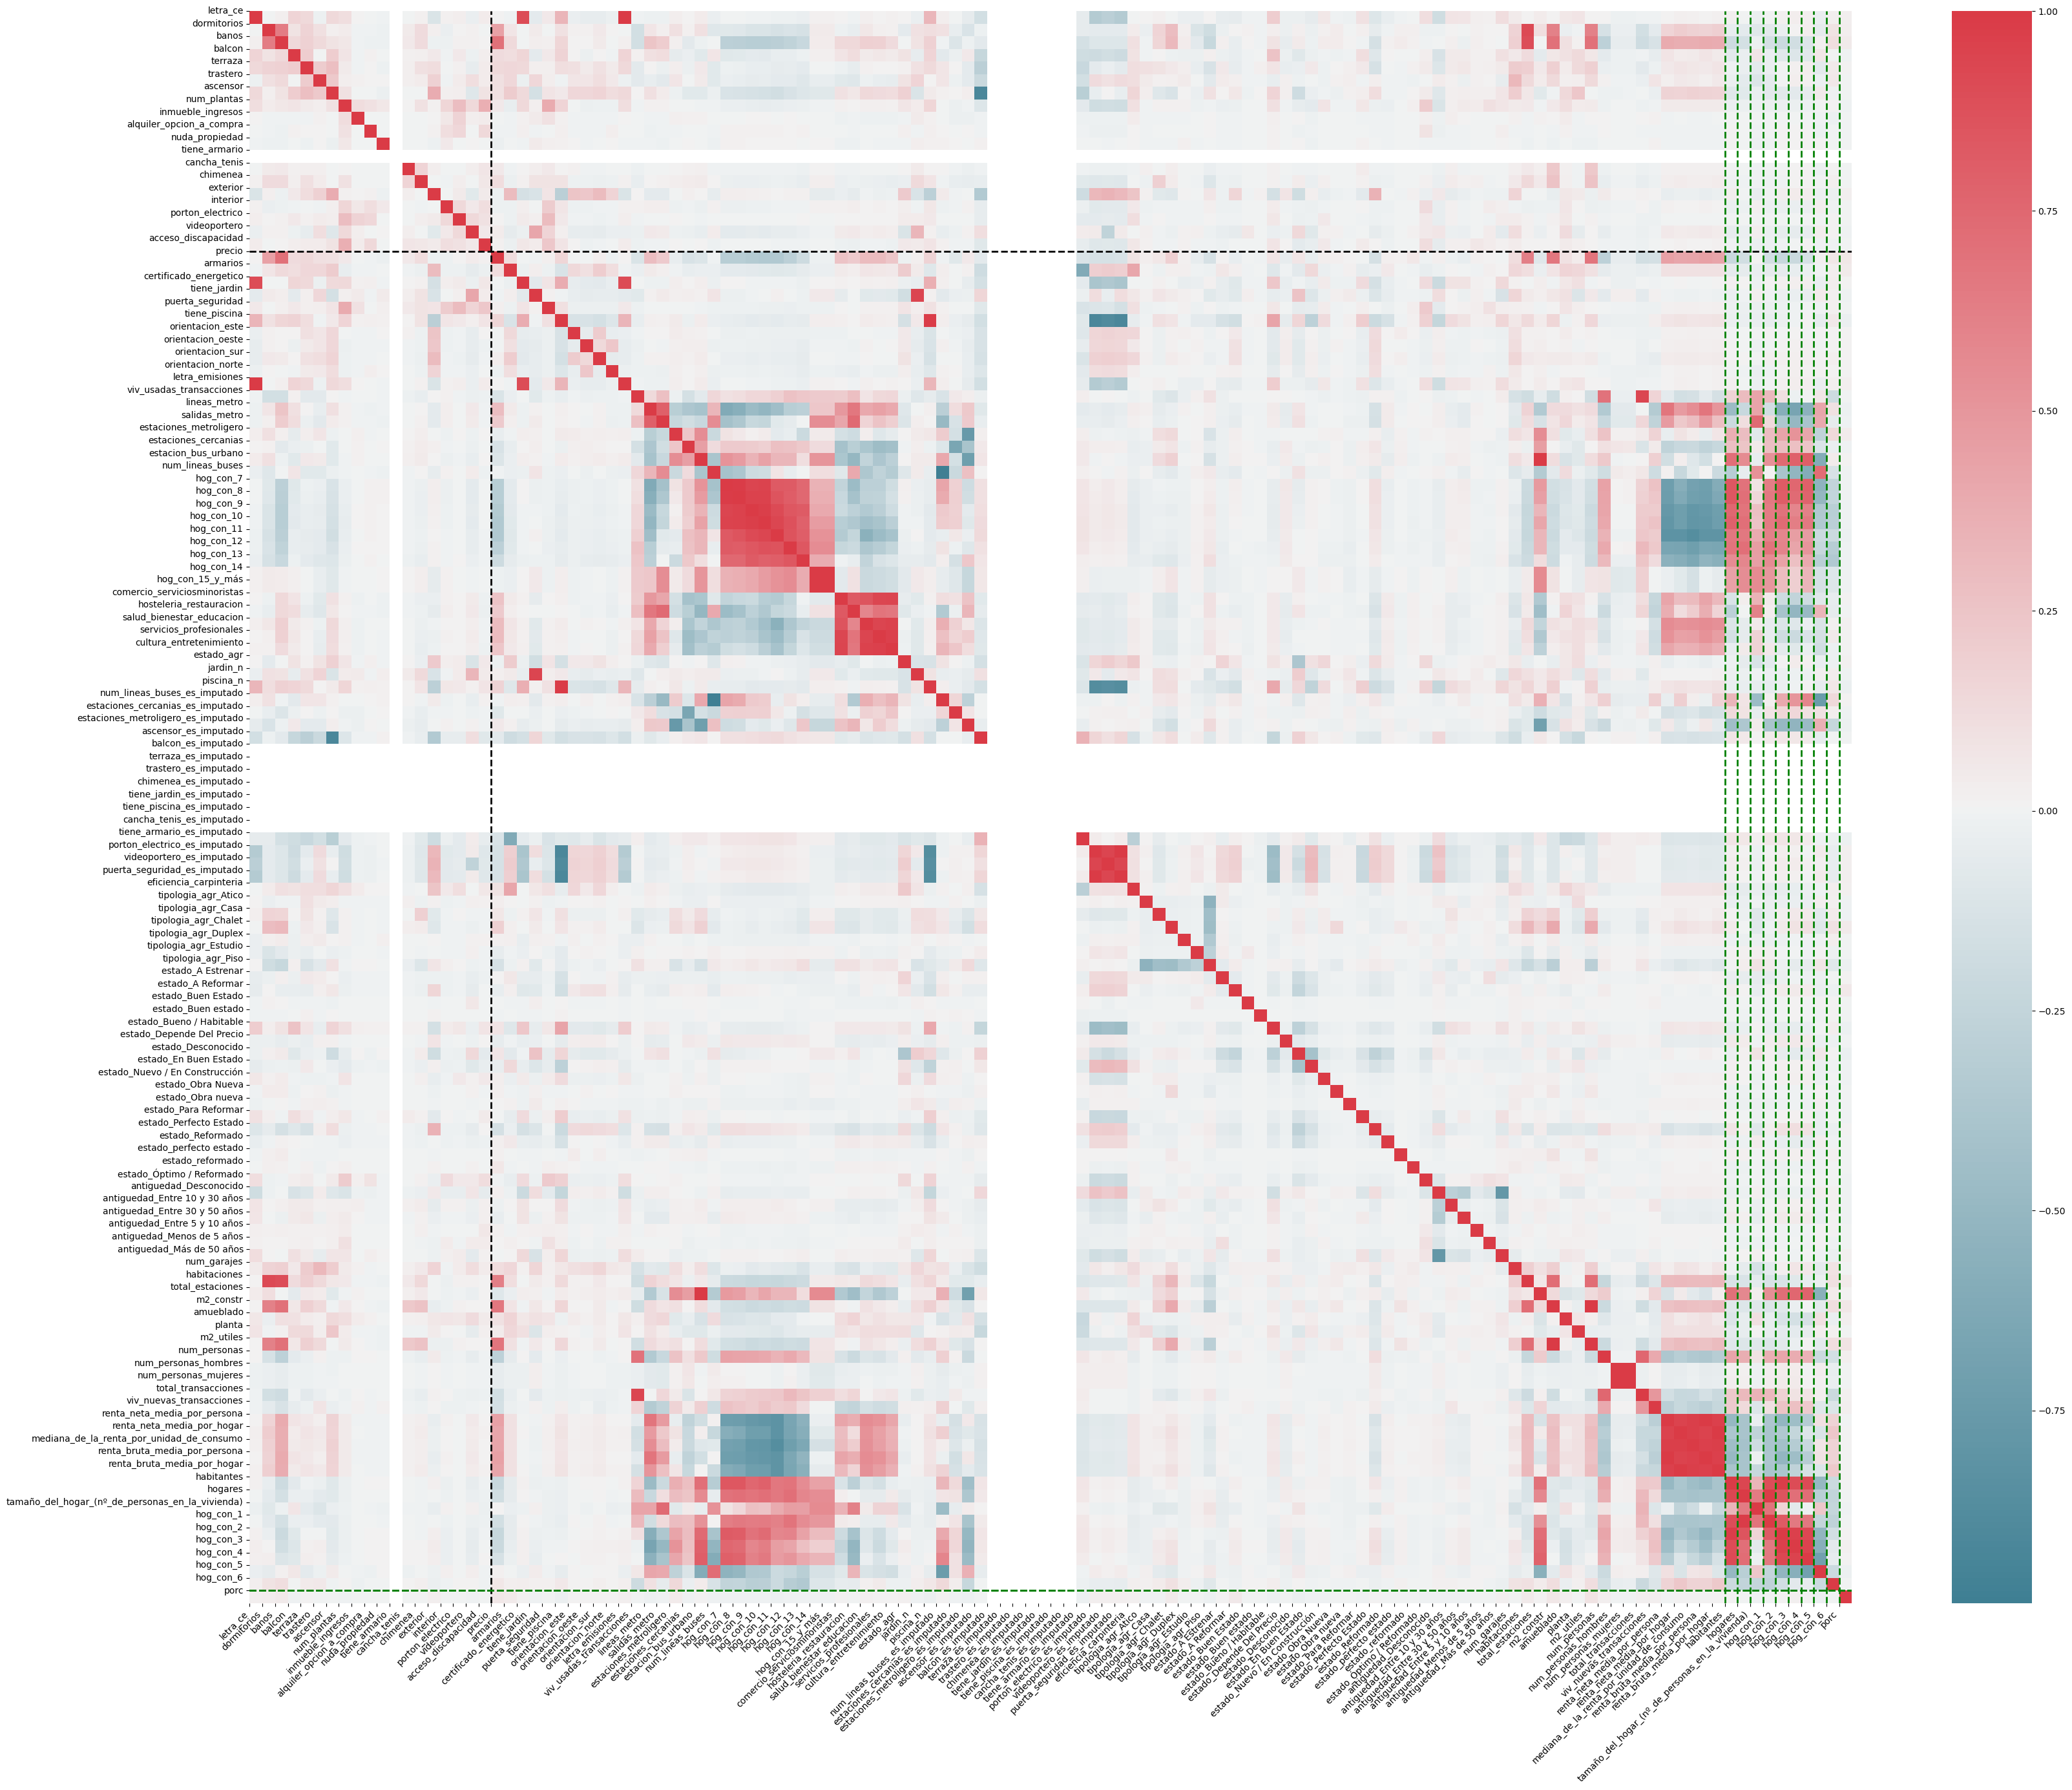

In [236]:
# Dibujar una matriz de correlación con las variables numéricas, marcando en negro, las líneas de correlación de la variable 'tarjget', y en verde las líneas de las correlaciones más altas
df_corr=dfEDAOHE[cols_num]
corr = df_corr.corr()
target = 'precio'
fig, _ = plt.subplots(figsize=(40, 32))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap = colormap)

target_idx = corr.columns.get_loc(target)  # Obtener la posición de la columna target
# Resaltar la columna y fila de la variable target con color naranja
target_idx = corr.columns.get_loc(target)  # Obtener la posición de la columna target
plt.axhline(target_idx, color='black', linewidth=2, linestyle='--')  # Línea naranja horizontal
plt.axvline(target_idx, color='black', linewidth=2, linestyle='--')  # Línea naranja vertical

# Identificar las 5 correlaciones más altas
corr_abs = corr.abs()  # Tomamos el valor absoluto para encontrar las correlaciones más fuertes
mask = np.triu(np.ones(corr.shape), k=1)  # Solo consideramos la mitad superior de la matriz (sin la diagonal)
high_corr_indices = np.unravel_index(np.argsort(corr_abs.where(mask == 1), axis=None)[-10:], corr.shape)

# Resaltar las 5 correlaciones más altas en verde
for i in range(10):
    row, col = high_corr_indices[0][i], high_corr_indices[1][i]
    plt.axhline(row, color='green', linewidth=2, linestyle='--')  # Línea verde horizontal
    plt.axvline(col, color='green', linewidth=2, linestyle='--')  # Línea verde vertical


plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje X para mejor visibilidad
plt.yticks(rotation=0)  # Asegurarse que las etiquetas del eje Y no se roten
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [237]:
dfEDA

,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,chimenea,exterior,interior,piscina,porton_electrico,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta_neta_media_por_persona,renta_neta_media_por_hogar,mediana_de_la_renta_por_unidad_de_consumo,renta_bruta_media_por_persona,renta_bruta_media_por_hogar,habitantes,hogares,tamaño_medio_del_hogar,tamaño_del_hogar_(nº_de_personas_en_la_vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15_y_más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,m2_areasverdes,estado_agr,tipologia_agr,jardin_n,piscina_n,porc,num_lineas_buses_es_imputado,estaciones_cercanias_es_imputado,estaciones_metroligero_es_imputado,ascensor_es_imputado,balcon_es_imputado,terraza_es_imputado,trastero_es_imputado,chimenea_es_imputado,tiene_jardin_es_imputado,tiene_piscina_es_imputado,cancha_tenis_es_imputado,tiene_armario_es_imputado,porton_electrico_es_imputado,videoportero_es_imputado,puerta_seguridad_es_imputado,eficiencia_carpinteria,tipologia_agr_Atico,tipologia_agr_Casa,tipologia_agr_Chalet,tipologia_agr_Duplex,tipologia_agr_Estudio,tipologia_agr_Piso,estado_A Estrenar,estado_A Reformar,estado_Buen Estado,estado_Buen estado,estado_Bueno / Habitable,estado_Depende Del Precio,estado_Desconocido,estado_En Buen Estado,estado_Nuevo / En Construcción,estado_Obra Nueva,estado_Obra nueva,estado_Para Reformar,estado_Perfecto Estado,estado_Reformado,estado_perfecto estado,estado_reformado,estado_Óptimo / Reformado,antiguedad_Desconocido,antiguedad_Entre 10 y 30 años,antiguedad_Entre 30 y 50 años,antiguedad_Entre 5 y 10 años,antiguedad_Menos de 5 años,antiguedad_Más de 50 años,num_garajes,tipo_garaje,habitaciones,total_estaciones,sistema_calefaccion
0,https://www.indomio.es/anuncios/75404850/,100.00,Salamanca,4,Recoletos,41,2,Atico,Para Reformar,0.10,1.00,1,1,1,1,1.0,1,1,Desconocido,0,0,0,0,0,lujo,1,1,0,1,0,1,0,1,1,2000000,Indomio.com,0,28001.00,80.00,Desconocido,1,0,1,100,1,Desconocido,Desconocido,0.50,0,0,0,Desconocido,Desconocido,0,2,Central,No clasificado en energía,Radiadores,15.44,6.97,8.48,243.00,8.00,235,6,18,0,1,186,0,28.14,64.93,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173,98,38,11,10,8,9,30,30,2470,1051,928,2315,917,"333526,92",1,Atico,0,1,0.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,NaN,2,205,Central
1,https://www.indomio.es/anuncios/79178265/,83.00,Barajas,21,Casco Histórico De Barajas,213,0,Piso,Bueno / Habitable,1.00,0.50,2,2,0,1,1.0,0,1,Entre 10 y 30 años,2,0,1,0,0,medio,1,0,0,0,1,0,0,0,1,287000,Indomio.com,0,28042.00,66.40,Desconocido,0,0,1,123,1,Desconocido,Desconocido,0,0,0,0,Sin Aire,Abierta,0,0,Individual,Electrica,Radiadores,7.38,3.52,3.87,94.00,12.00,82,2,6,0,2,144,0,20.79,54.34,26.95,27.12,70.91,48.65,18.52,"2,63",4.69,5.05,3.83,3.44,1.00,290.00,113.00,44,39,12,3,3,0,0,7,7,399,345,125,522,108,"1904384,53",2,Piso,0,1,0.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,NaN,4,152,Eléctrica


<!-- Puntos a realizar...

*  Normalizar los valores en barrio. Hecho
*  Normalizar los valores en Tipologia.Hecho
*  Rellenar nulos en las columnas  para hacer el Clustering...
* Analizar de manera mas profunda feature engineering . -->

In [238]:
# Forzar la recolección de basura
gc.collect()

36

In [239]:
# dfEDA.to_csv("dfEDA_final.csv",index='False')

# *11. Dataset para generación del modelo*
En el análisis estadístico hemos identificado las variables que consideramos que son importantes para enfocarnos para hacer un modelo *baseline*.

In [240]:
# cols = [ 'url','cod_barrio', 'letra_ce', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'num_plantas', 'tiene_armario', 'cancha_tenis', 'chimenea', 'exterior', 'interior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'precio', 'armarios', 'codigo_postal', 'certificado_energetico', 'num_visitas', 'num_pisos', 'puerta_seguridad', 'gastos_comunidad', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'viv_usadas_transacciones', 'lineas_metro', 'num_lineas_buses', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15 y más', 'comercio_serviciosminoristas', 'hosteleria_restauracion',
#        'salud_bienestar_educacion', 'servicios_profesionales', 'cultura_entretenimiento', 'tipologia_agr_Atico', 'tipologia_agr_Chalet', 'tipologia_agr_Duplex', 'tipologia_agr_Estudio', 'tipologia_agr_Piso', 'eficiencia_carpinteria', 'estado_Buen estado', 'estado_Desconocido', 'estado_Obra nueva', 'estado_Para reformar', 'estado_Reformado', 'num_garajes', 'antiguedad_Entre 10 y  15 Años', 'antiguedad_Entre 10 y 30 años', 'antiguedad_Entre 30 y 50 años', 'antiguedad_Entre 5 y 10 años', 'antiguedad_Menos de 5 años', 'antiguedad_Más de 50 años', 'antiguedad_nan', 'jardin_n', 'piscina_n',
#        'cocina_sin_informacion', 'cocina_reformada', 'cocina_sinreformada', 'cocina_amueblada', 'cocina_sin_amueblar', 'cocina_equipada', 'cocina_independiente', 'cocina_abierta', 'total_estaciones',
# 'm2_constr', 'amueblado', 'planta', 'm2_utiles', 'num_personas', 'num_personas_hombres', 'num_personas_mujeres', 'total_transacciones', 'viv_nuevas_transacciones', 'renta neta media por persona', 'renta neta media por hogar', 'mediana de la renta por unidad de consumo', 'renta bruta media por persona', 'renta bruta media por hogar', 'habitantes', 'hogares', 'tamaño del hogar (nº de personas en la vivienda)', 'hog_con_1', 'hog_con_2', 'hog_con_3', 'hog_con_4', 'hog_con_5', 'hog_con_6', 'porc', 'euros_m2', 'precio_medio_barrio']

In [241]:
# dfbaseline = dfEDA[cols]

In [242]:
# dfEDA.to_csv("dfbaseline.csv",index='False')